# Make all the plots in the paper but better (for thesis)

Use all the data, sort out the formatting.

---

In [8]:
import os
from pathlib import Path

import alphashape as ap
import descartes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import shapely
from alphashape.optimizealpha import _testalpha
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

plt.style.use("seaborn-colorblind")
%matplotlib inline

In [9]:
IMGS = Path("../img/")
DATA = Path("../data/")

## Helper functions

In [10]:
def get_summary(experiment, write=False):
    """ Get the combined experiment summary for an experiment. """

    dfs = []
    for path in (DATA / experiment / "data").glob("*/summary/main.csv"):
        seed = int(path.parts[-3])
        df = pd.read_csv(path)
        df["seed"] = seed
        dfs.append(df)

    summary = pd.concat(dfs)
    summary = summary.sort_values(["generation", "individual", "seed"])

    if write is True:
        out = DATA / experiment / "summary"
        out.mkdir(exist_ok=True)
        summary.to_csv(out / "main.csv", index=False)

    return summary


def get_idxs(summary):
    """ Get the indices of those individuals with the minimum, (approx.) median
    and maximum fitnesses from an experiment summary. """

    fitness = summary["fitness"].values

    min_idx = fitness.argmin()
    max_idx = fitness.argmax()

    diff = np.abs(fitness - np.median(fitness))
    med_idx = diff.argmin()

    return min_idx, med_idx, max_idx


def write_representatives(summary, experiment):
    """ Write the representative individuals for an experiment. Assumes the original data
    is unpacked from its tarball. """

    idxs = get_idxs(summary)

    for idx, case in zip(idxs, ("min", "med", "max")):

        gen, ind, seed = map(
            str, summary[["generation", "individual", "seed"]].iloc[idx, :]
        )

        out = DATA / experiment / "summary" / case
        out.mkdir(exist_ok=True, parents=True)

        path = DATA / experiment / "data" / seed / "data" / gen / ind

        with open(out / "README", "w") as readme:
            readme.write(f"Invididual {ind} of generation {gen} in trial {seed}.")

        os.system(f"cp -r {path}/main.* {out}")


def get_representatives(experiment):
    """ Get the representative individuals for an experiment. """

    representatives = {}
    for case in ("min", "med", "max"):
        out = DATA / experiment / "summary" / case
        df = pd.read_csv(out / "main.csv")
        representatives[case] = df

    return representatives

## Plot functions

### Progressions

In [11]:
def progression_boxplot(
    summary, column, ylabel, yscale=None, epochs=None, filename=None
):
    """ Create boxplots for the progression of an attribute in an experiment summary. """

    _, ax = plt.subplots(dpi=300)

    if epochs:
        summary = summary[summary["generation"].isin(epochs)]

    data = summary.groupby("generation")[column]

    flierprops = dict(marker=".", markersize=2.5, linestyle="none", alpha=0.05)

    xticklabels = []
    for pos, (epoch, subdata) in enumerate(data):
        ax.boxplot(subdata, positions=[pos], widths=0.5, flierprops=flierprops)
        xticklabels.append(epoch)

    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("Epoch")

    if yscale:
        ax.set_yscale(yscale)

    ax.set_ylabel(ylabel)

    plt.tight_layout()
    if filename:
        plt.savefig(IMGS / filename, transparent=True)

### Scattering individuals

In [12]:
def individuals_scatterplot(representatives, order, filename=None):
    """ Plot side-by-side scatters for the representative individuals in an experiment. """

    _, axes = plt.subplots(ncols=3, figsize=(12, 4), dpi=300)

    for ax, case, title in zip(axes, order, ("Worst", "Median", "Best")):

        df = representatives[case]
        km = KMeans(n_clusters=2, random_state=0).fit(df)

        ax.scatter(df["0"], df["1"], c=km.labels_, edgecolors="k", lw=0.5)
        ax.scatter(
            km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=100,
            marker="X",
            c=[0, 1],
            edgecolors="k",
            lw=0.5,
        )

        ax.set_title("    ".join((title, f"(Inertia: {km.inertia_:.4e})")), pad=15)

    plt.tight_layout()
    if filename:
        plt.savefig(IMGS / filename, transparent=True)

### Scattering individuals with hulls

In [13]:
def get_clustering_and_score(df, method):
    """ Get the clustering method object and the silhouette score of the dataset. """

    if method == "kmeans":
        clustering = KMeans(n_clusters=3, random_state=0).fit(df)
    if method == "dbscan":
        clustering = DBSCAN(eps=0.1, min_samples=5).fit(df)

    try:
        score = silhouette_score(df, clustering.labels_)
    except ValueError:
        score = np.nan

    return clustering, score


def optimise_alpha(points, max_iter=100, tol=1e-3, upper=1000):
    """ Find the optimal value for alpha-shape concave hull via bisection. """

    points = shapely.geometry.MultiPoint(points)
    lower, itr = 0, 0
    while (upper - lower) > tol and itr < max_iter:

        itr += 1
        test = (upper + lower) / 2
        if _testalpha(points, test):
            lower = test
        else:
            upper = test

    return lower


def plot_hulls(data, labels, ax):
    """ Plot the convex and concave hulls to the axis. """

    measures, patches = [], []
    for label in set(labels):
        mask = labels == label
        points = data[mask, :]
        try:
            convex = scipy.spatial.ConvexHull(points)
            for simplex in convex.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], "k-", lw=1, zorder=1)

            alpha = optimise_alpha(points)
            concave_polygon = ap.alphashape(points, alpha)
            convex_polygon = shapely.geometry.Polygon(points[convex.vertices, :])

            patches.append(descartes.PolygonPatch(concave_polygon))
            measures.append(round(concave_polygon.area / convex_polygon.area, 3))

        except (scipy.spatial.qhull.QhullError, ZeroDivisionError):
            measures.append(1.0)

    mean_convexity = np.mean(measures).round(3)
    measures.append(f"Mean: {mean_convexity}")

    collection = PatchCollection(patches, zorder=0, alpha=0.3)
    ax.add_collection(collection)

    return ax, measures


def convexity_scatterplot(representatives, order, method, filename=None):
    """ Plot side-by-side scatters and convex hulls for the representative
    individuals in an experiment with the given method. """

    _, axes = plt.subplots(ncols=3, figsize=(12, 4), dpi=300)
    method_to_title = {"kmeans": "$k$-means", "dbscan": "DBSCAN"}

    for ax, case, title in zip(axes, order, ("Worst", "Median", "Best")):

        df = representatives[case]
        clustering, score = get_clustering_and_score(df, method)

        outlier_mask = clustering.labels_ == -1
        outliers = df.values[outlier_mask, :]
        ax.scatter(
            outliers[:, 0], outliers[:, 1], c="k", edgecolors="k", s=5, lw=0.5, zorder=2
        )

        data = df.values[~outlier_mask, :]
        labels = clustering.labels_[~outlier_mask]
        scatter = ax.scatter(
            data[:, 0],
            data[:, 1],
            c=labels,
            label=labels,
            edgecolors="k",
            lw=0.5,
            zorder=2,
        )

        ax.set_title(
            "    ".join((title, f"({method_to_title[method]} silhouette: {score:.4f})"))
        )

        ax, measures = plot_hulls(data, labels, ax)

        handles, _ = scatter.legend_elements()
        ax.legend(
            handles + [Patch(facecolor="None", edgecolor="None")],
            measures,
            title="Cluster convexity",
            loc="upper left",
        )

    plt.tight_layout()
    if filename:
        plt.savefig(IMGS / filename, transparent=True)

## $k$-means (inertia) with $R = (3, 100)$

In [14]:
name = "kmeans_inertia_small_"
summary = get_summary("kmeans_inertia")
epochs = range(0, 101, 10)

representatives = get_representatives("kmeans_inertia")
order = ("max", "med", "min")

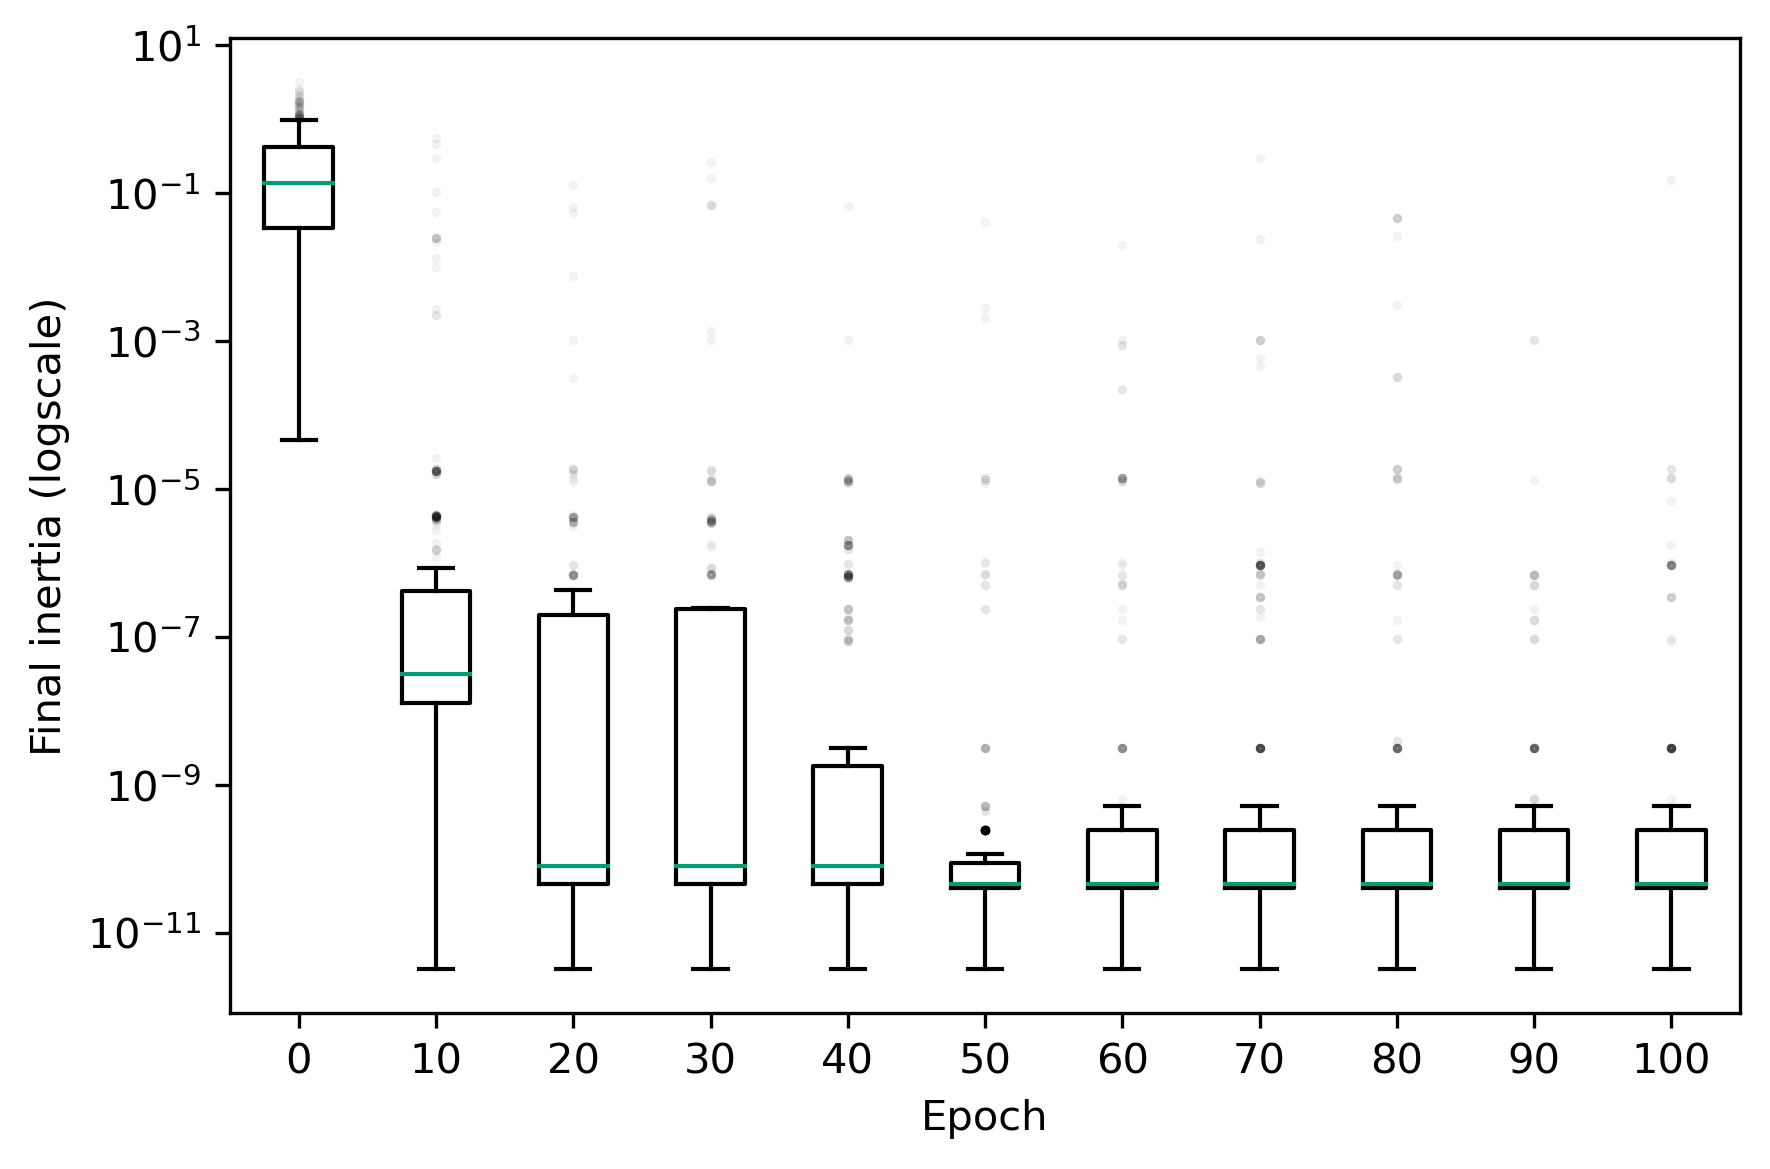

In [15]:
progression_boxplot(
    summary,
    "fitness",
    "Final inertia (logscale)",
    yscale="log",
    epochs=epochs,
    filename=name + "fitness.pdf",
)

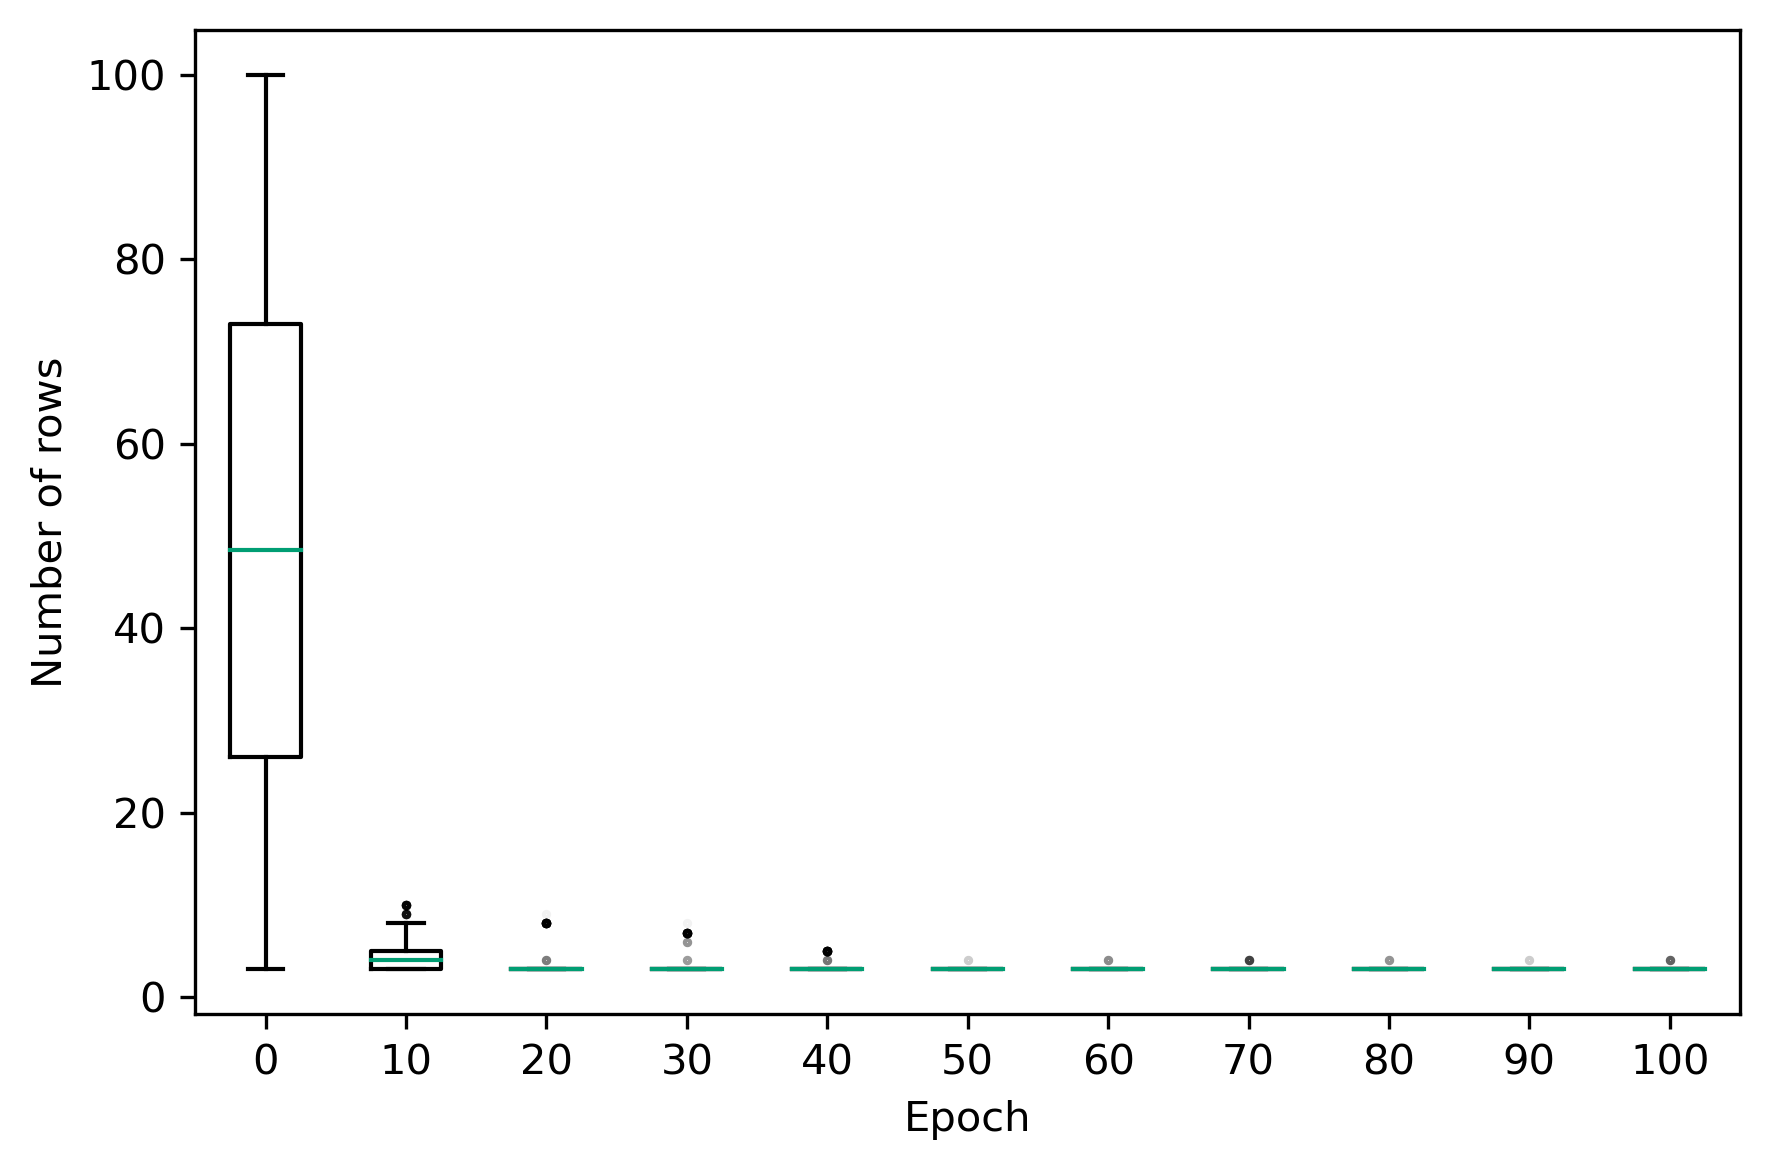

In [16]:
progression_boxplot(
    summary, "nrows", "Number of rows", epochs=epochs, filename=name + "nrows.pdf"
)

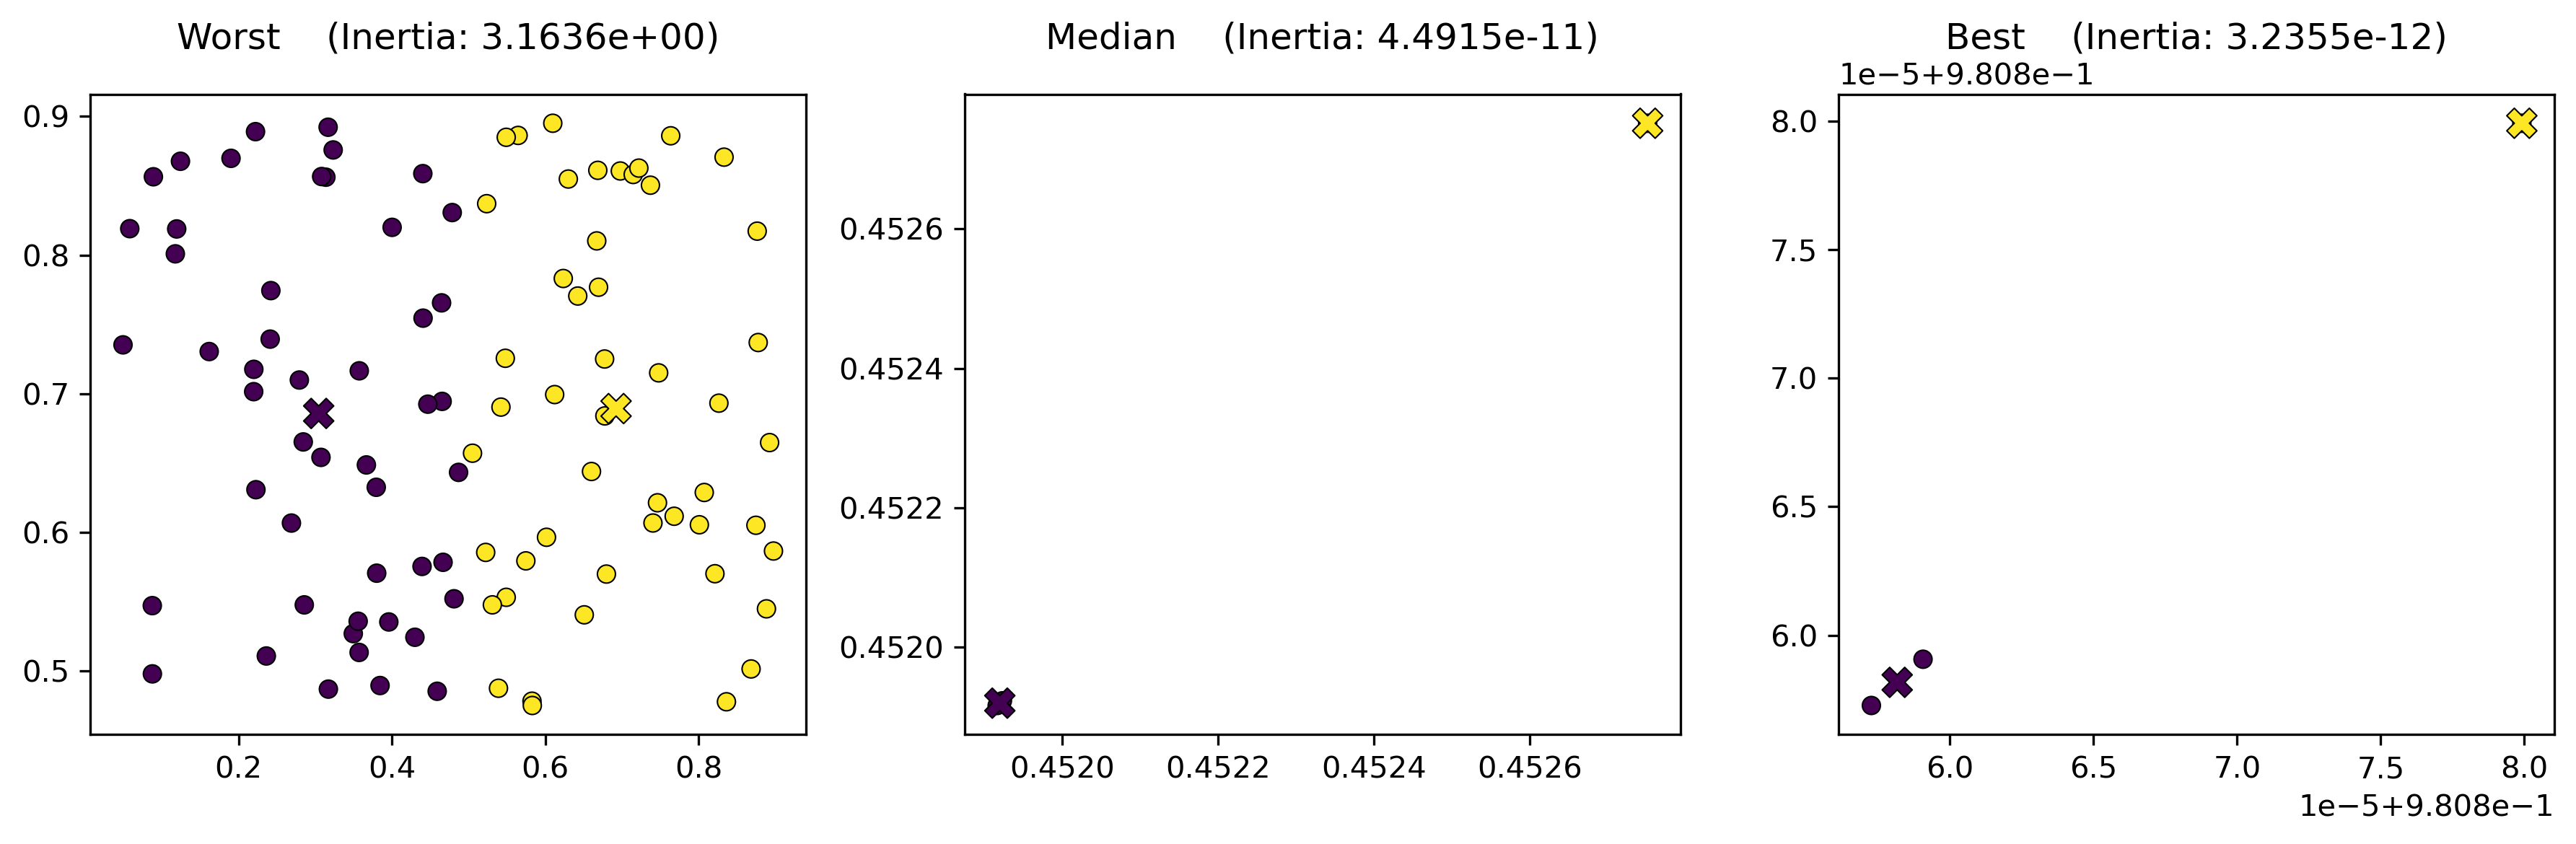

In [17]:
individuals_scatterplot(representatives, order, filename=name + "inds.pdf")

## $k$-means (inertia) with $R = (50, 100)$

In [18]:
name = "kmeans_inertia_large_"
summary = get_summary("kmeans_inertia_high")
epochs = range(0, 1001, 100)

representatives = get_representatives("kmeans_inertia_high")
order = ("max", "med", "min")

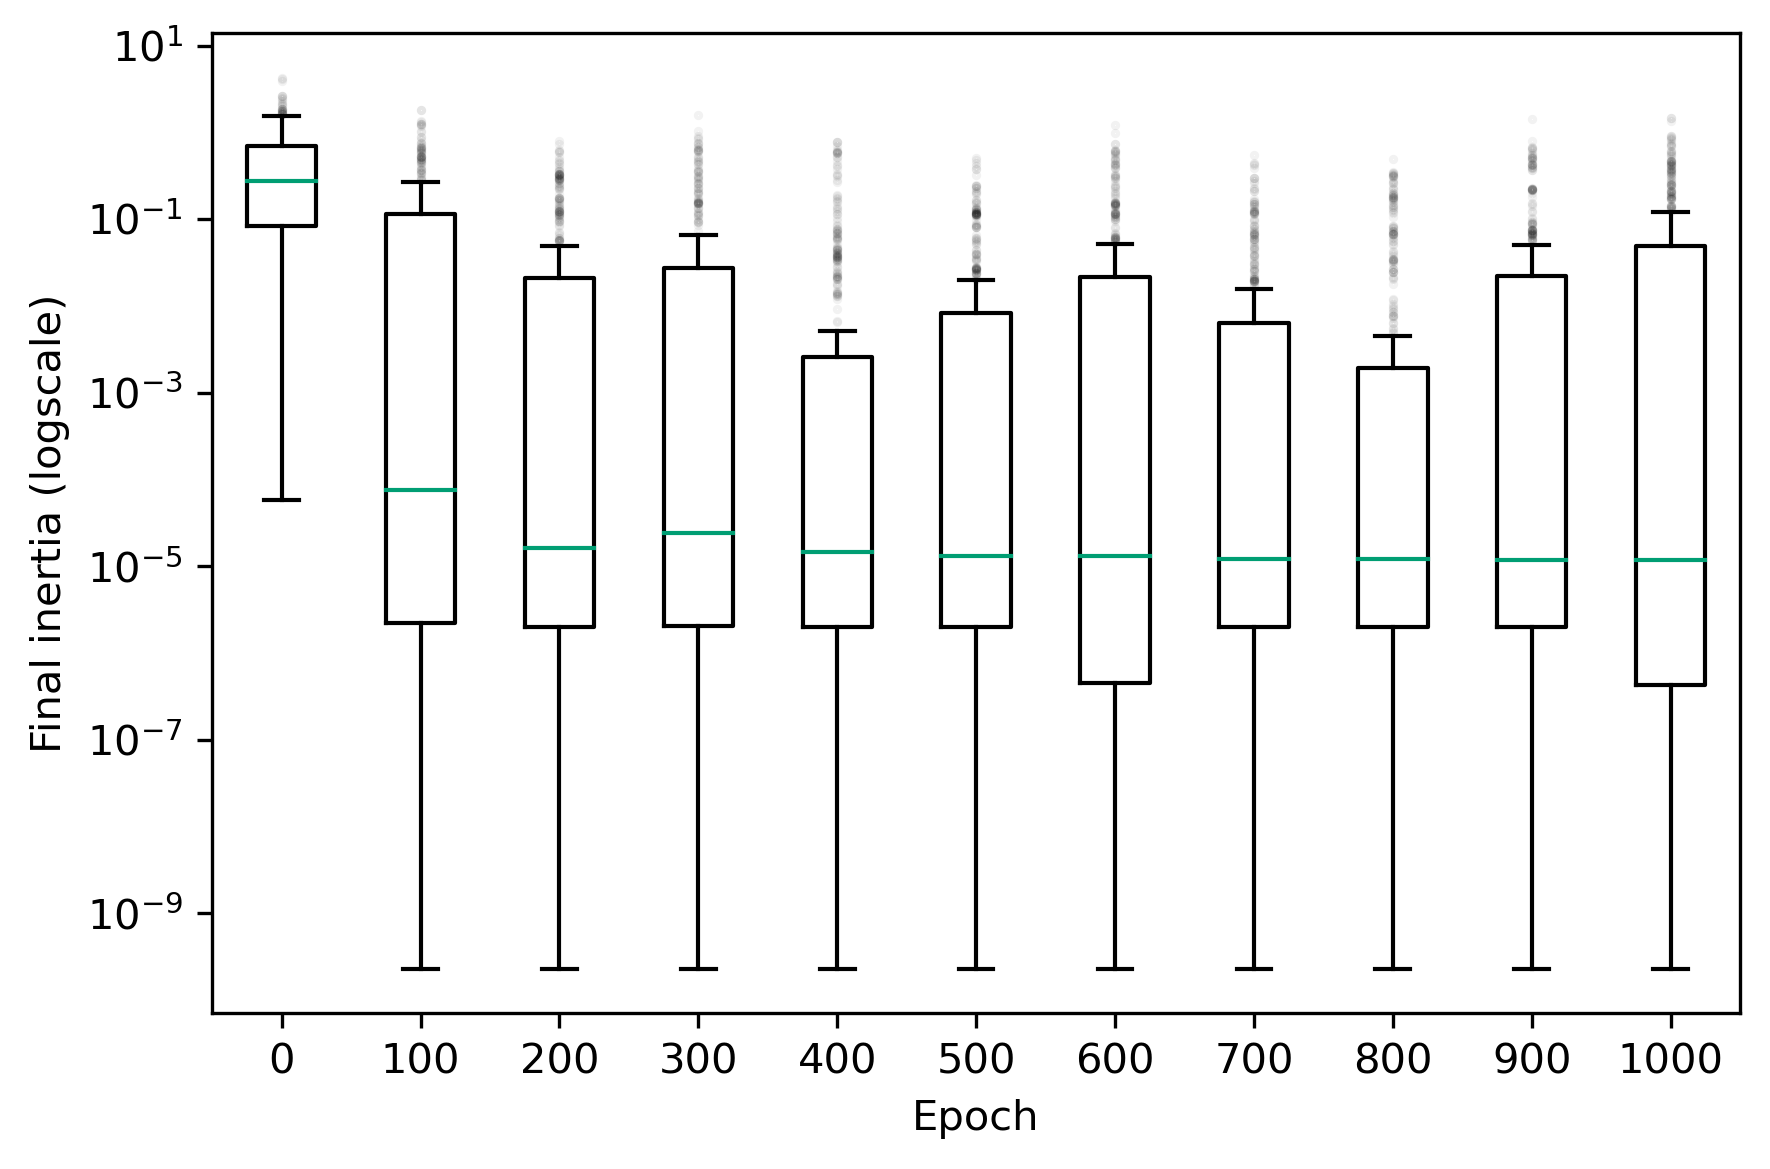

In [19]:
progression_boxplot(
    summary,
    "fitness",
    "Final inertia (logscale)",
    yscale="log",
    epochs=epochs,
    filename=name + "fitness.pdf",
)

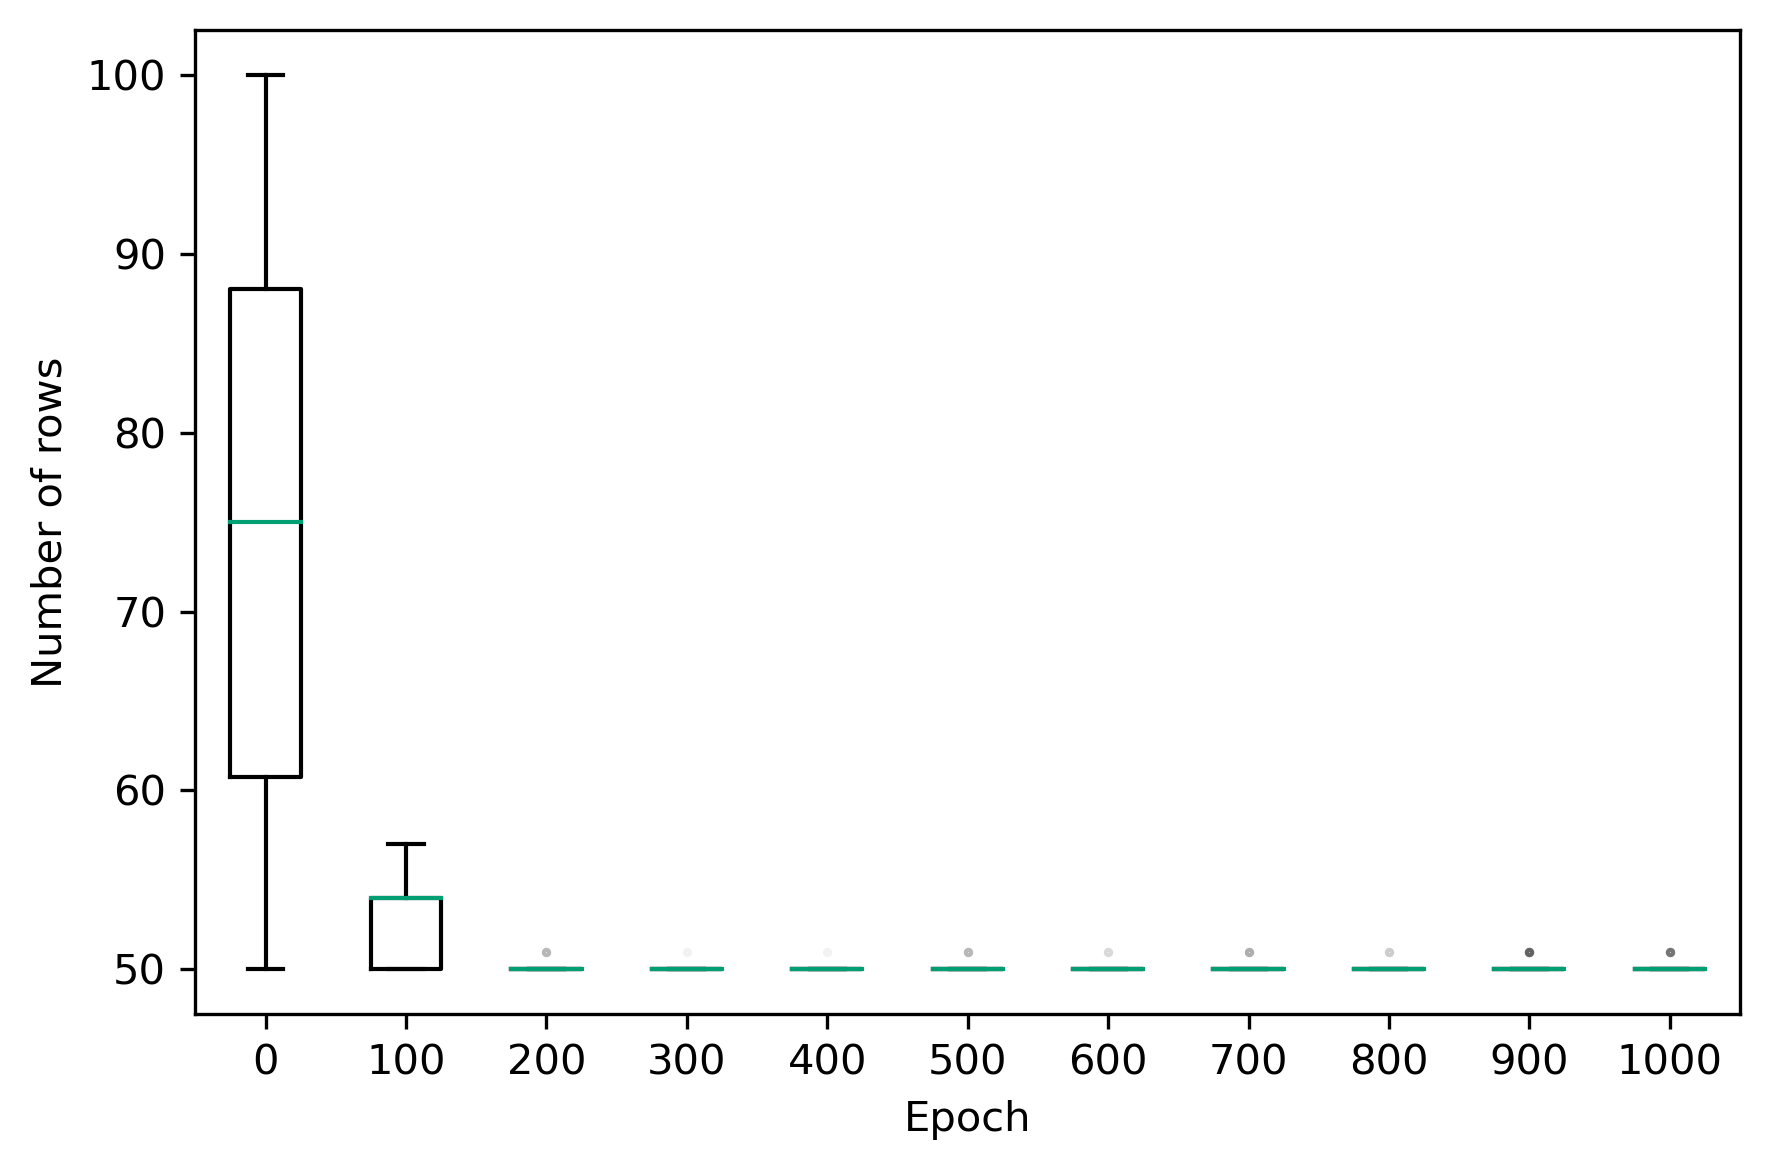

In [20]:
progression_boxplot(
    summary, "nrows", "Number of rows", epochs=epochs, filename=name + "nrows.pdf"
)

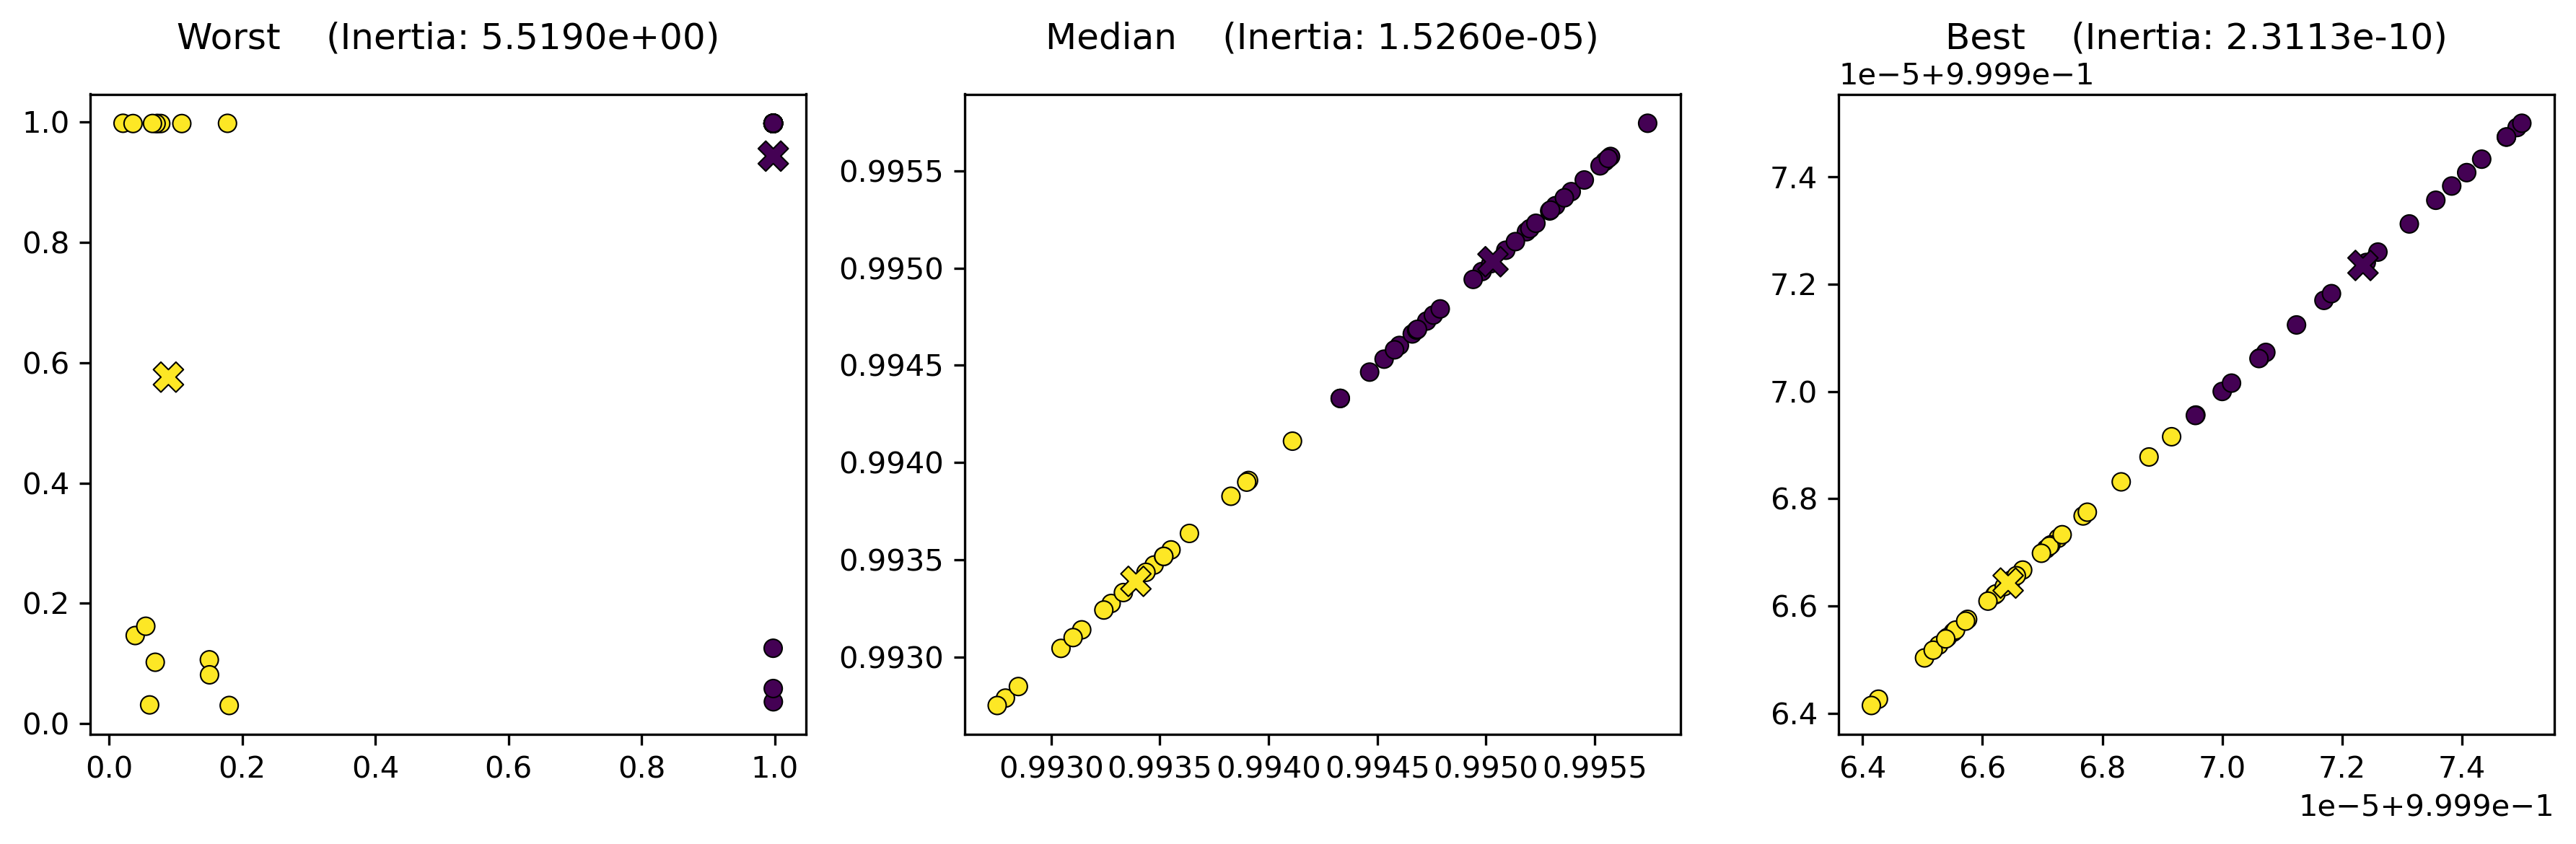

In [21]:
individuals_scatterplot(representatives, order, filename=name + "inds.pdf")

## $k$-means (silhouette) with $R=(3, 100)$

In [22]:
name = "kmeans_silhouette_small_"
summary = get_summary("kmeans_silhouette")
summary["fitness"] *= -1
epochs = range(0, 1001, 100)

representatives = get_representatives("kmeans_silhouette")
order = ("max", "med", "min")

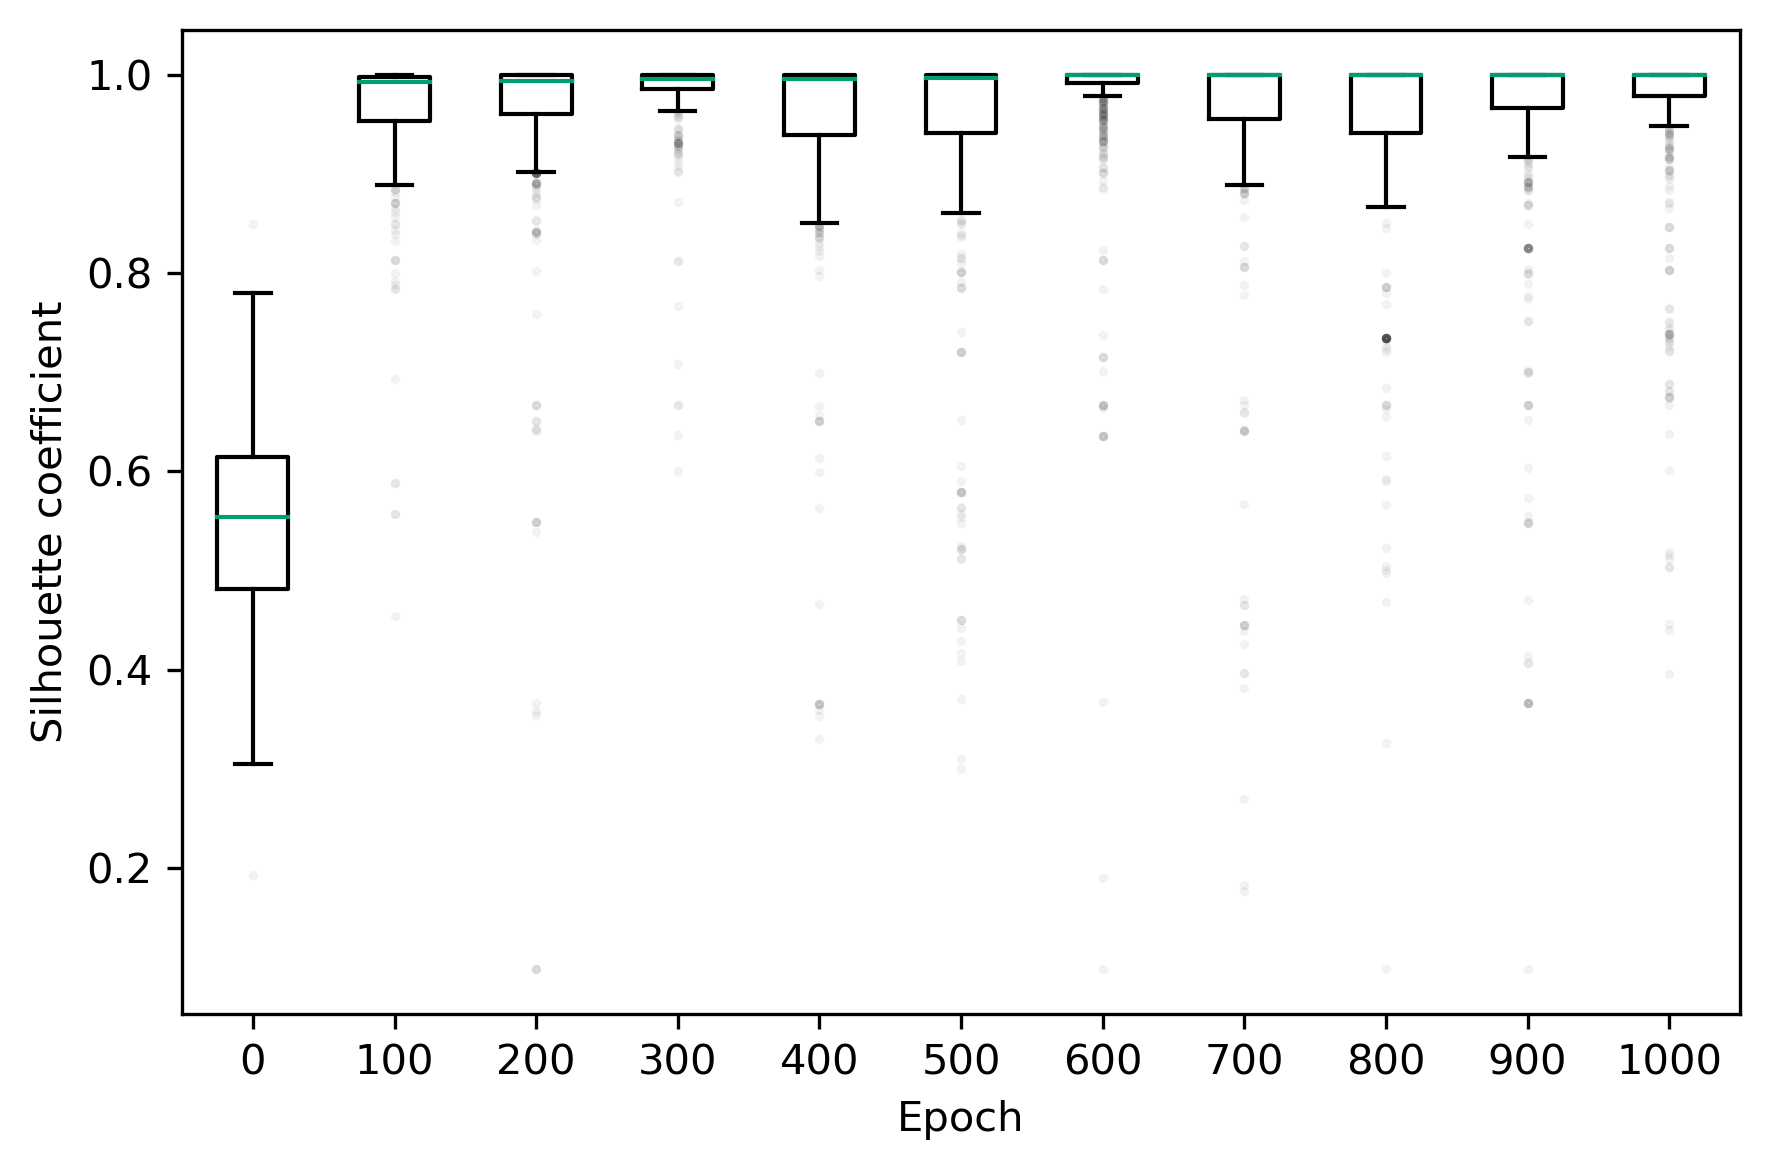

In [23]:
progression_boxplot(
    summary,
    "fitness",
    "Silhouette coefficient",
    epochs=epochs,
    filename=name + "fitness.pdf",
)

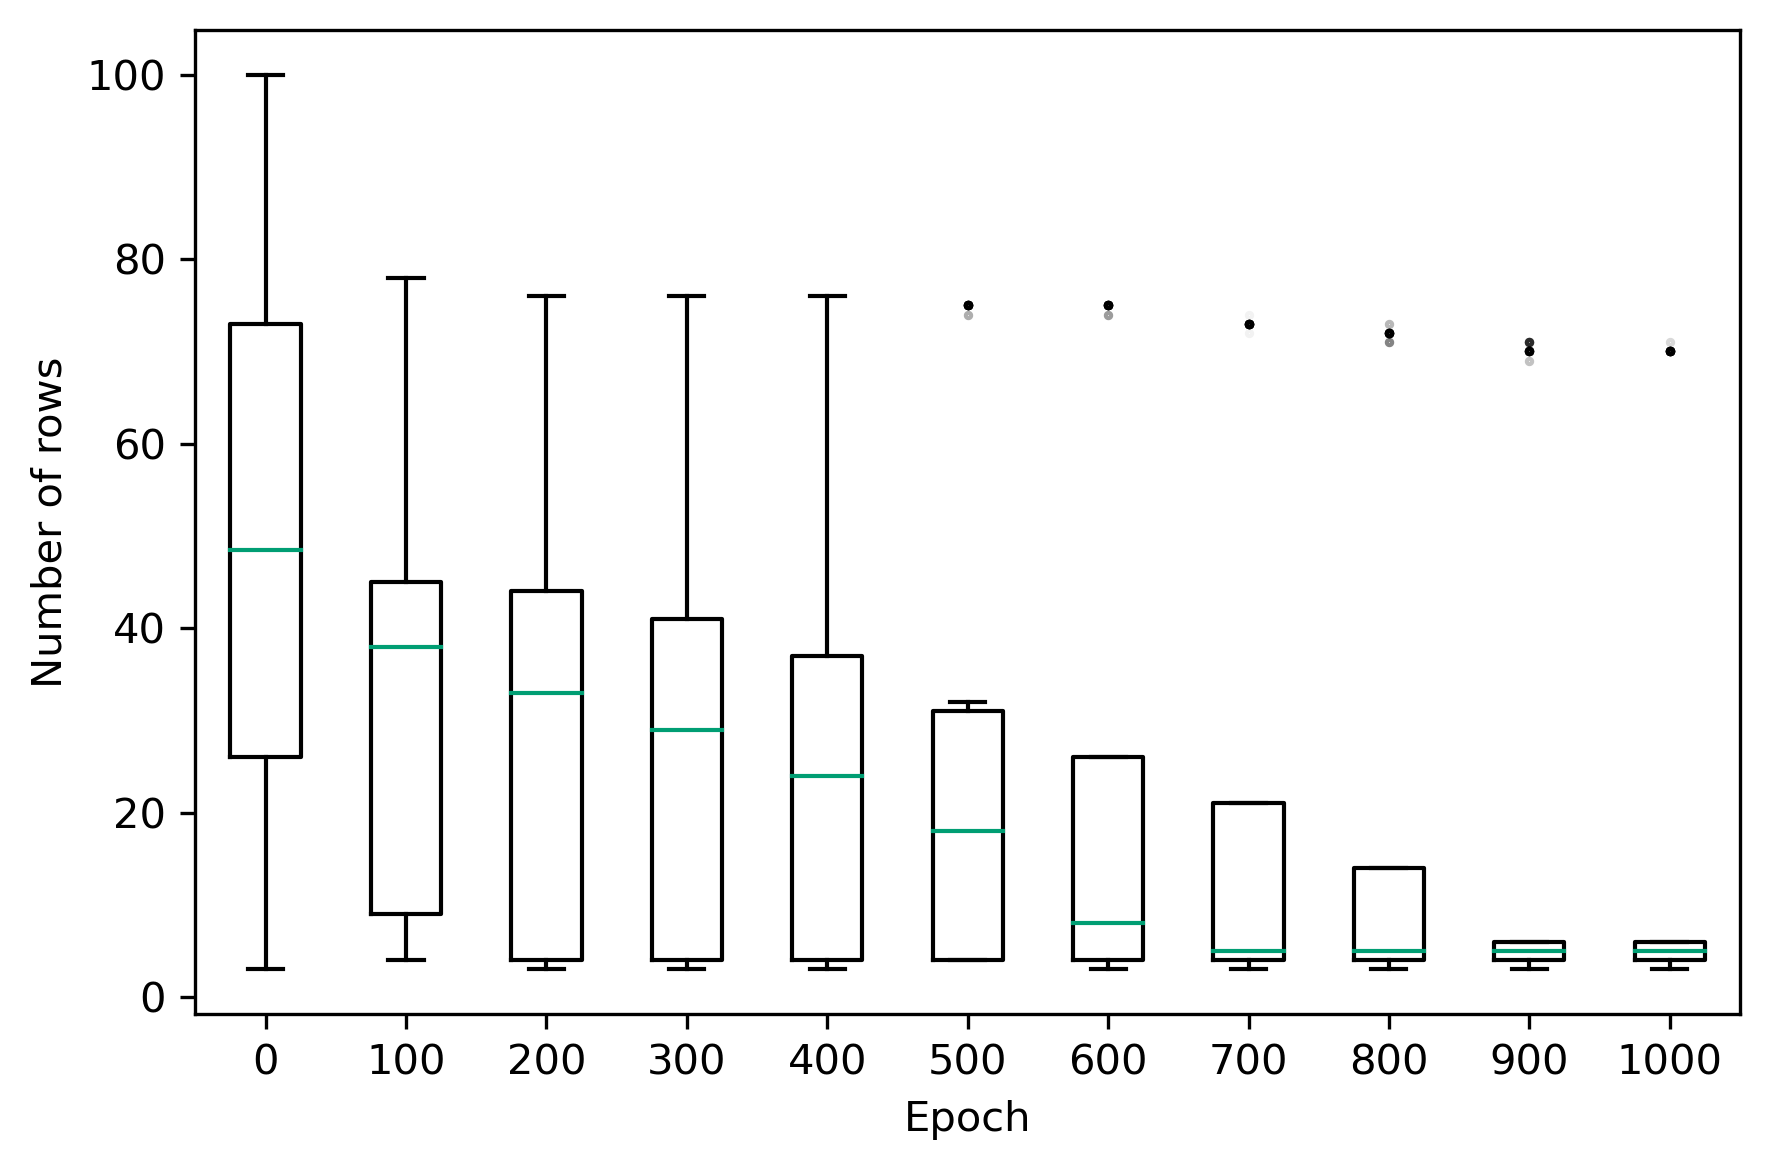

In [24]:
progression_boxplot(
    summary, "nrows", "Number of rows", epochs=epochs, filename=name + "nrows.pdf"
)

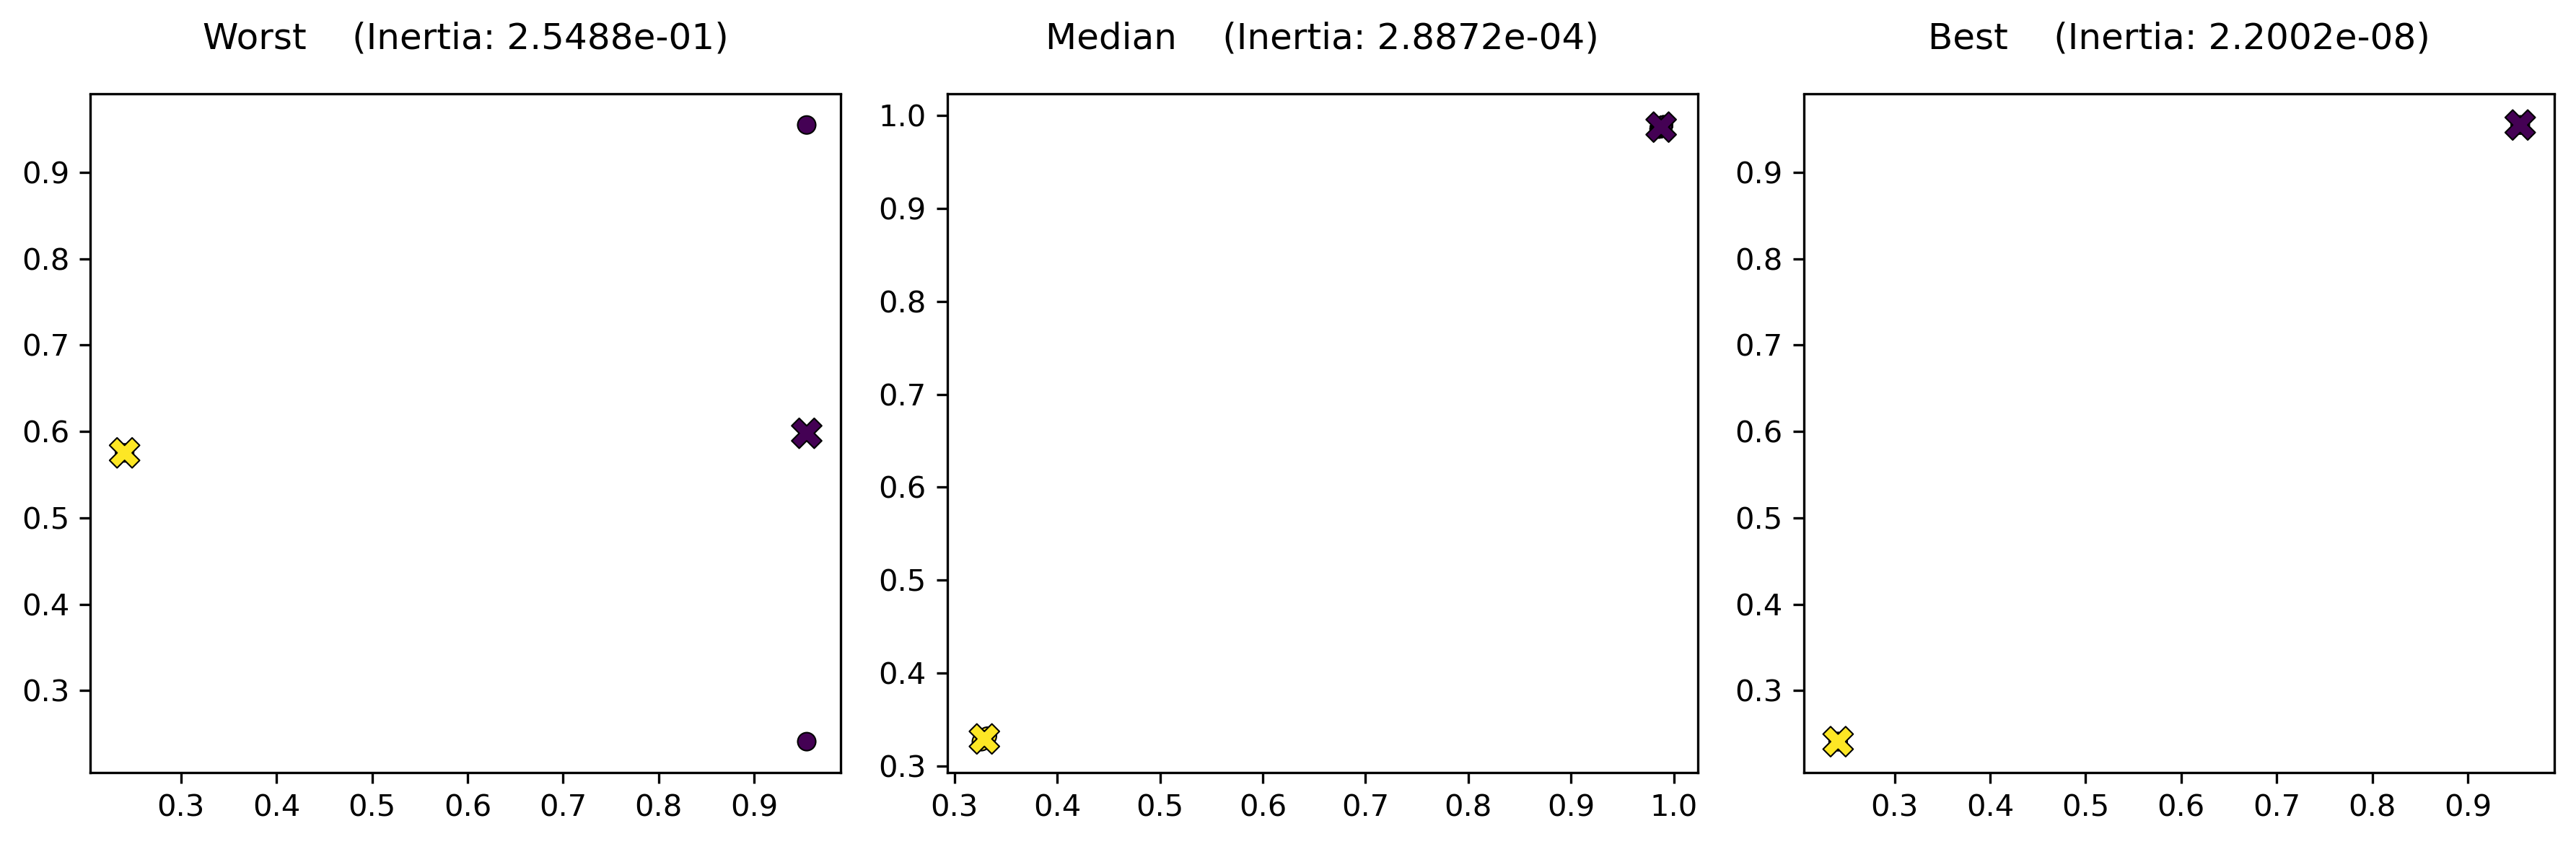

In [25]:
individuals_scatterplot(representatives, order, filename=name + "inds.pdf")

## $k$-means (silhouette) with $R = (50, 100)$

In [26]:
name = "kmeans_silhouette_large_"
summary = get_summary("kmeans_silhouette_high")
summary["fitness"] *= -1
epochs = range(0, 1001, 100)

representatives = get_representatives("kmeans_silhouette_high")
order = ("max", "med", "min")

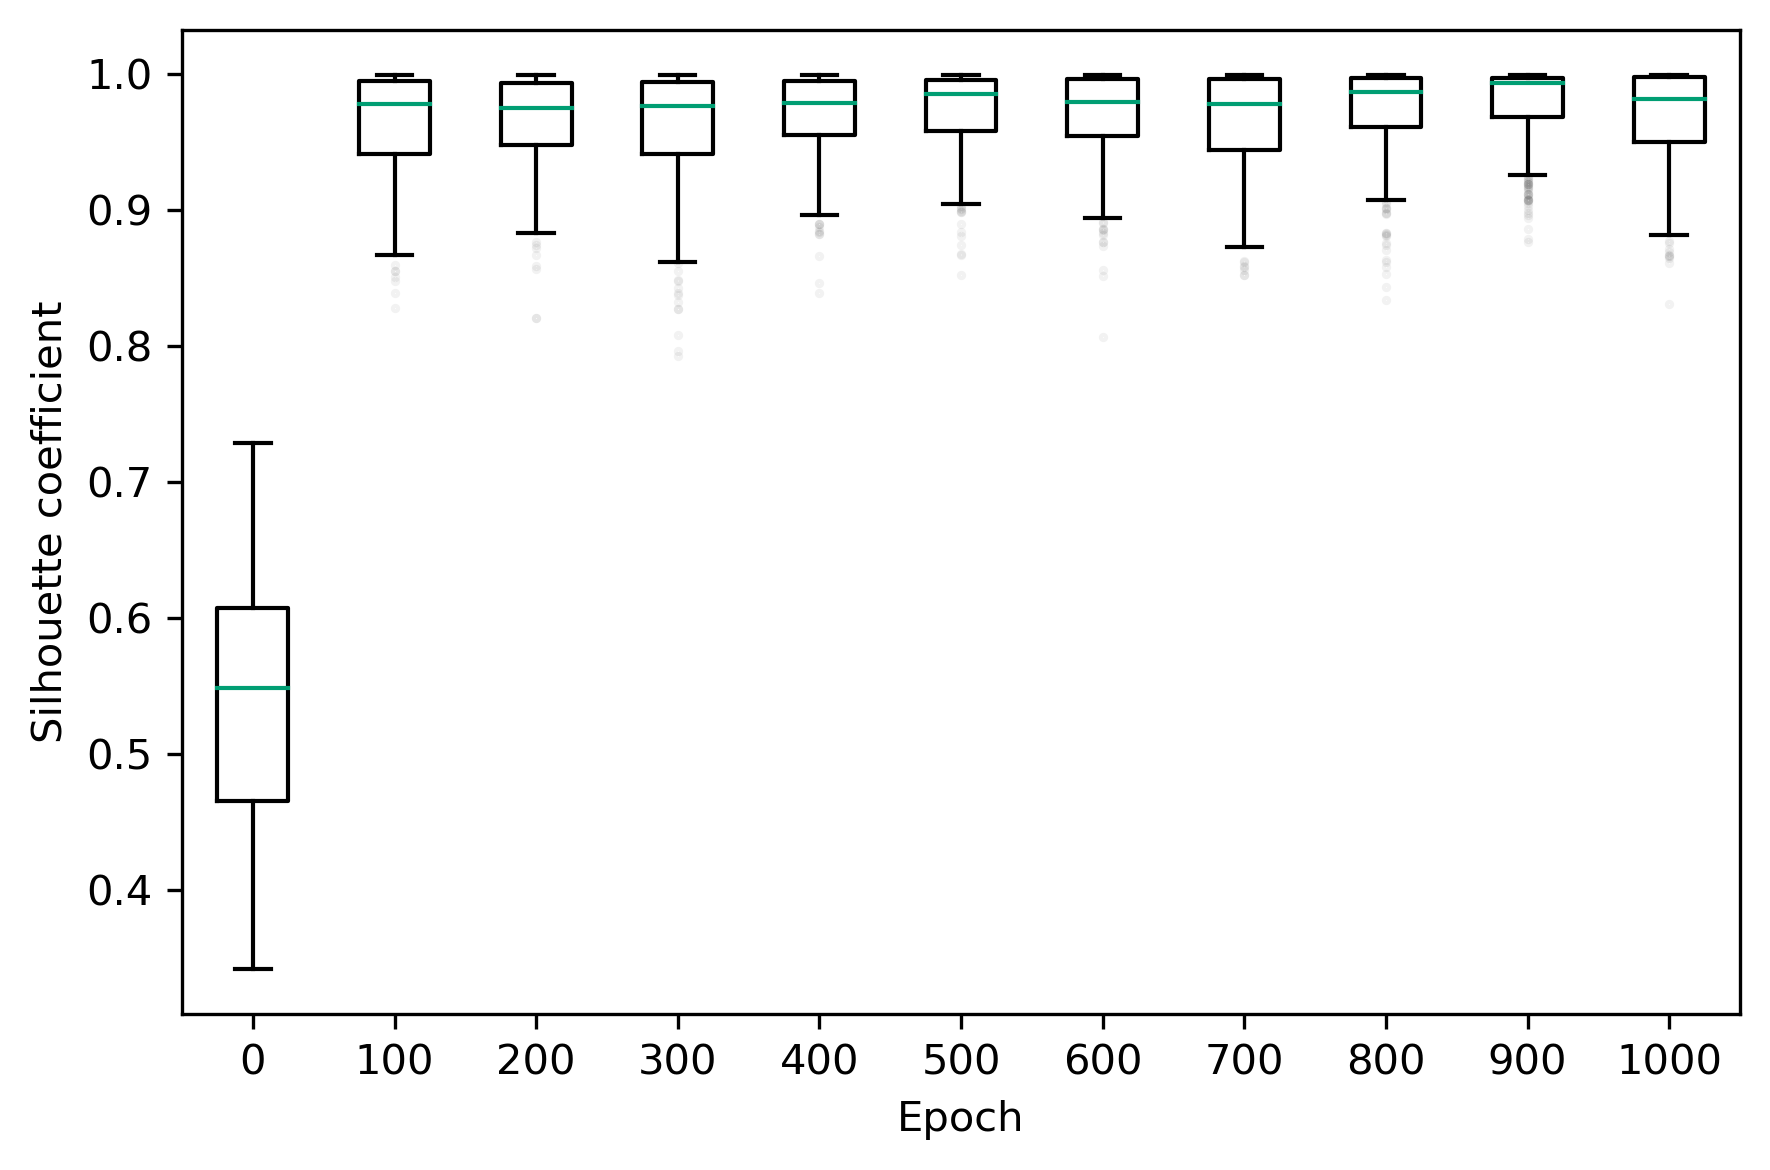

In [27]:
progression_boxplot(
    summary,
    "fitness",
    "Silhouette coefficient",
    epochs=epochs,
    filename=name + "fitness.pdf",
)

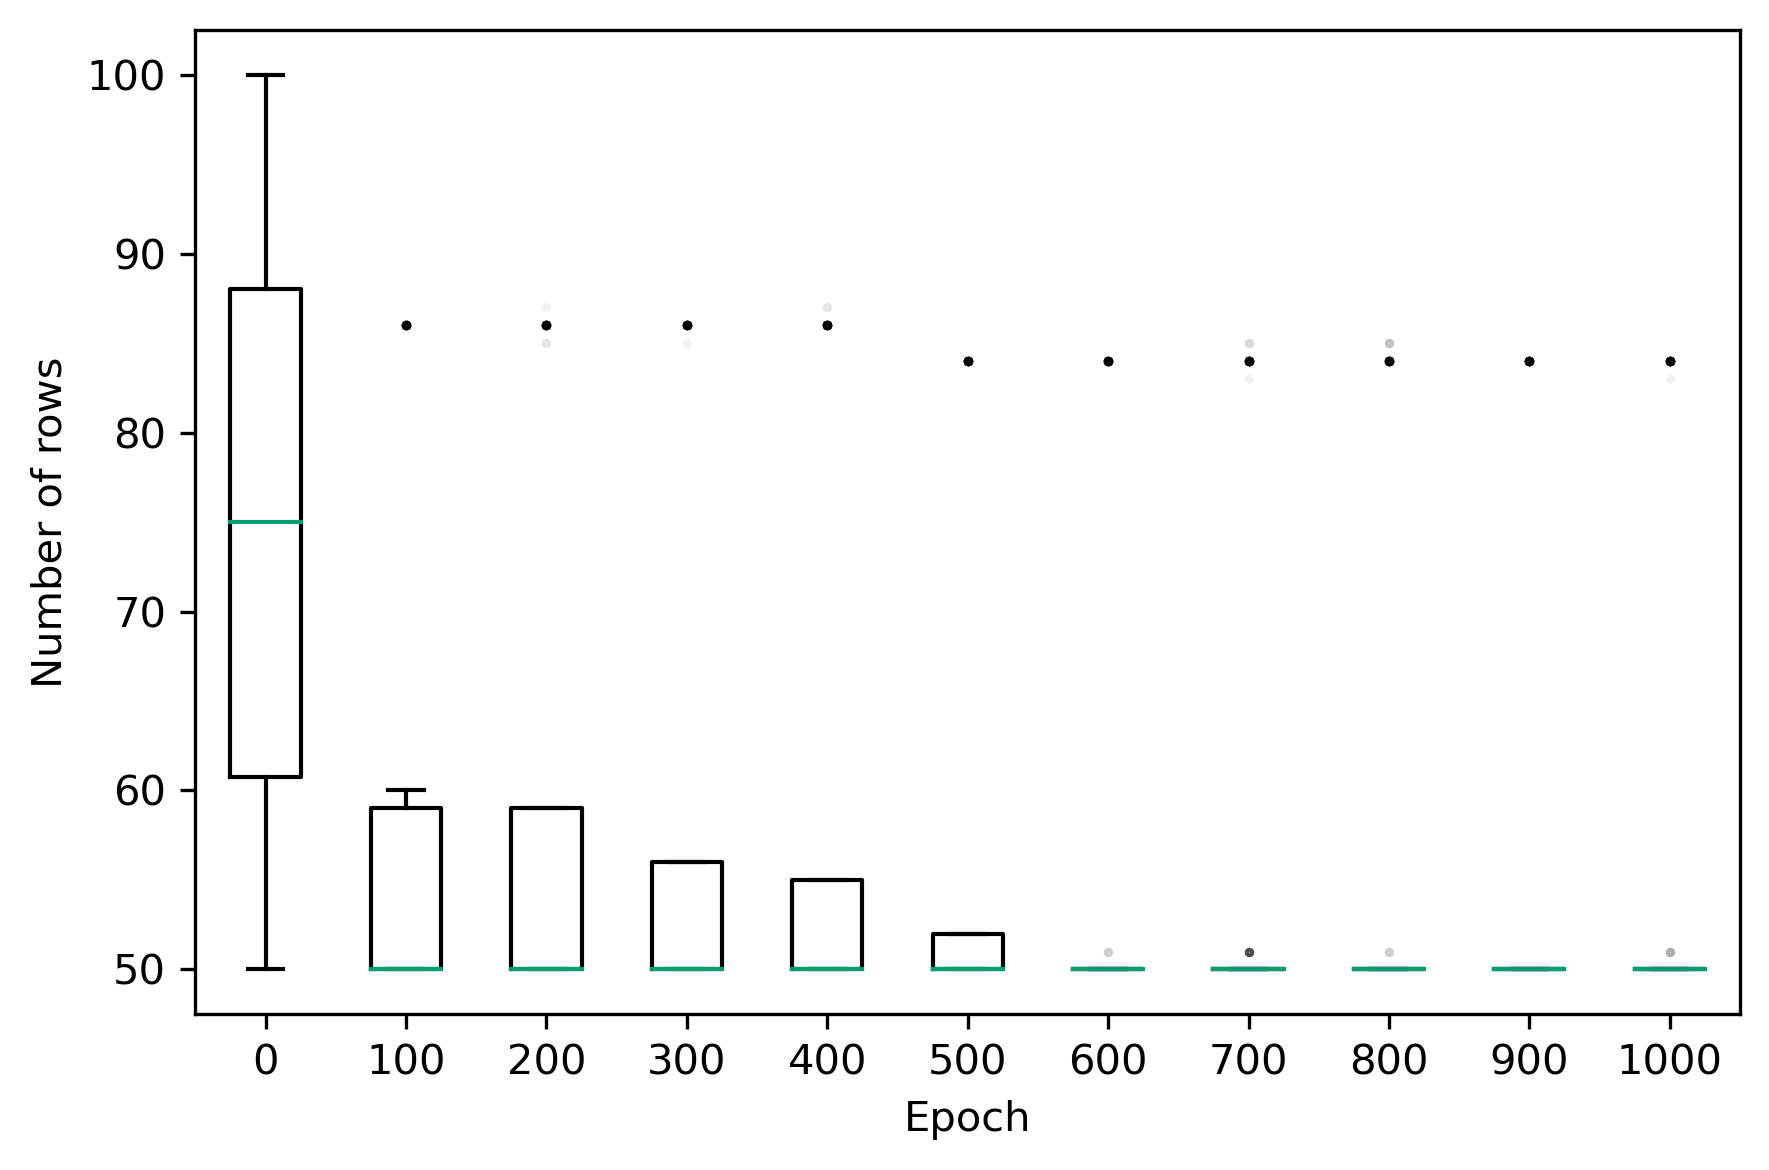

In [28]:
progression_boxplot(
    summary, "nrows", "Number of rows", epochs=epochs, filename=name + "nrows.pdf"
)

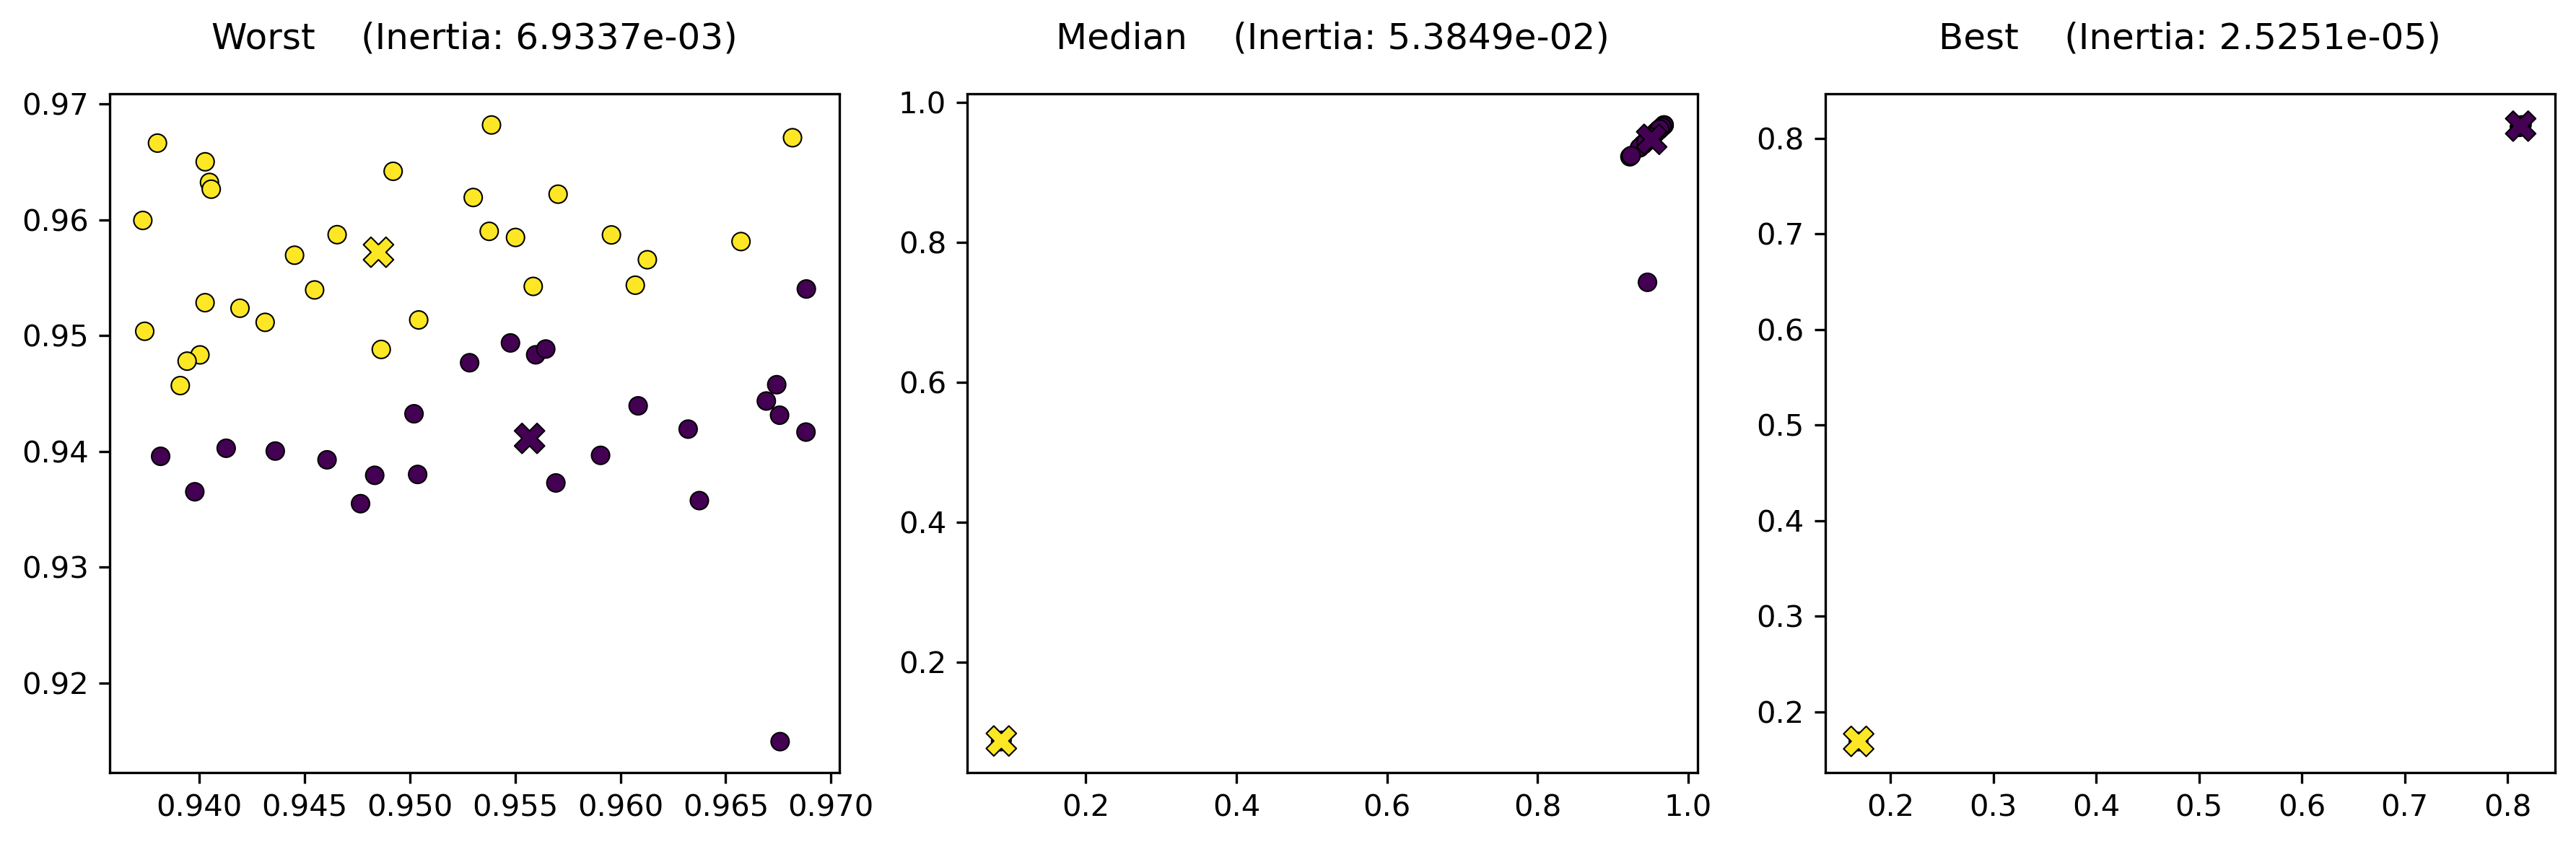

In [29]:
individuals_scatterplot(representatives, order, filename=name + "inds.pdf")

# $k$-means preferable over DBSCAN

In [30]:
name = "kmeans_over_dbscan_"
summary = get_summary("kmeans_over_dbscan")
epochs = range(0, 1001, 100)

representatives = get_representatives("kmeans_over_dbscan")
order = ("max", "med", "min")

/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]


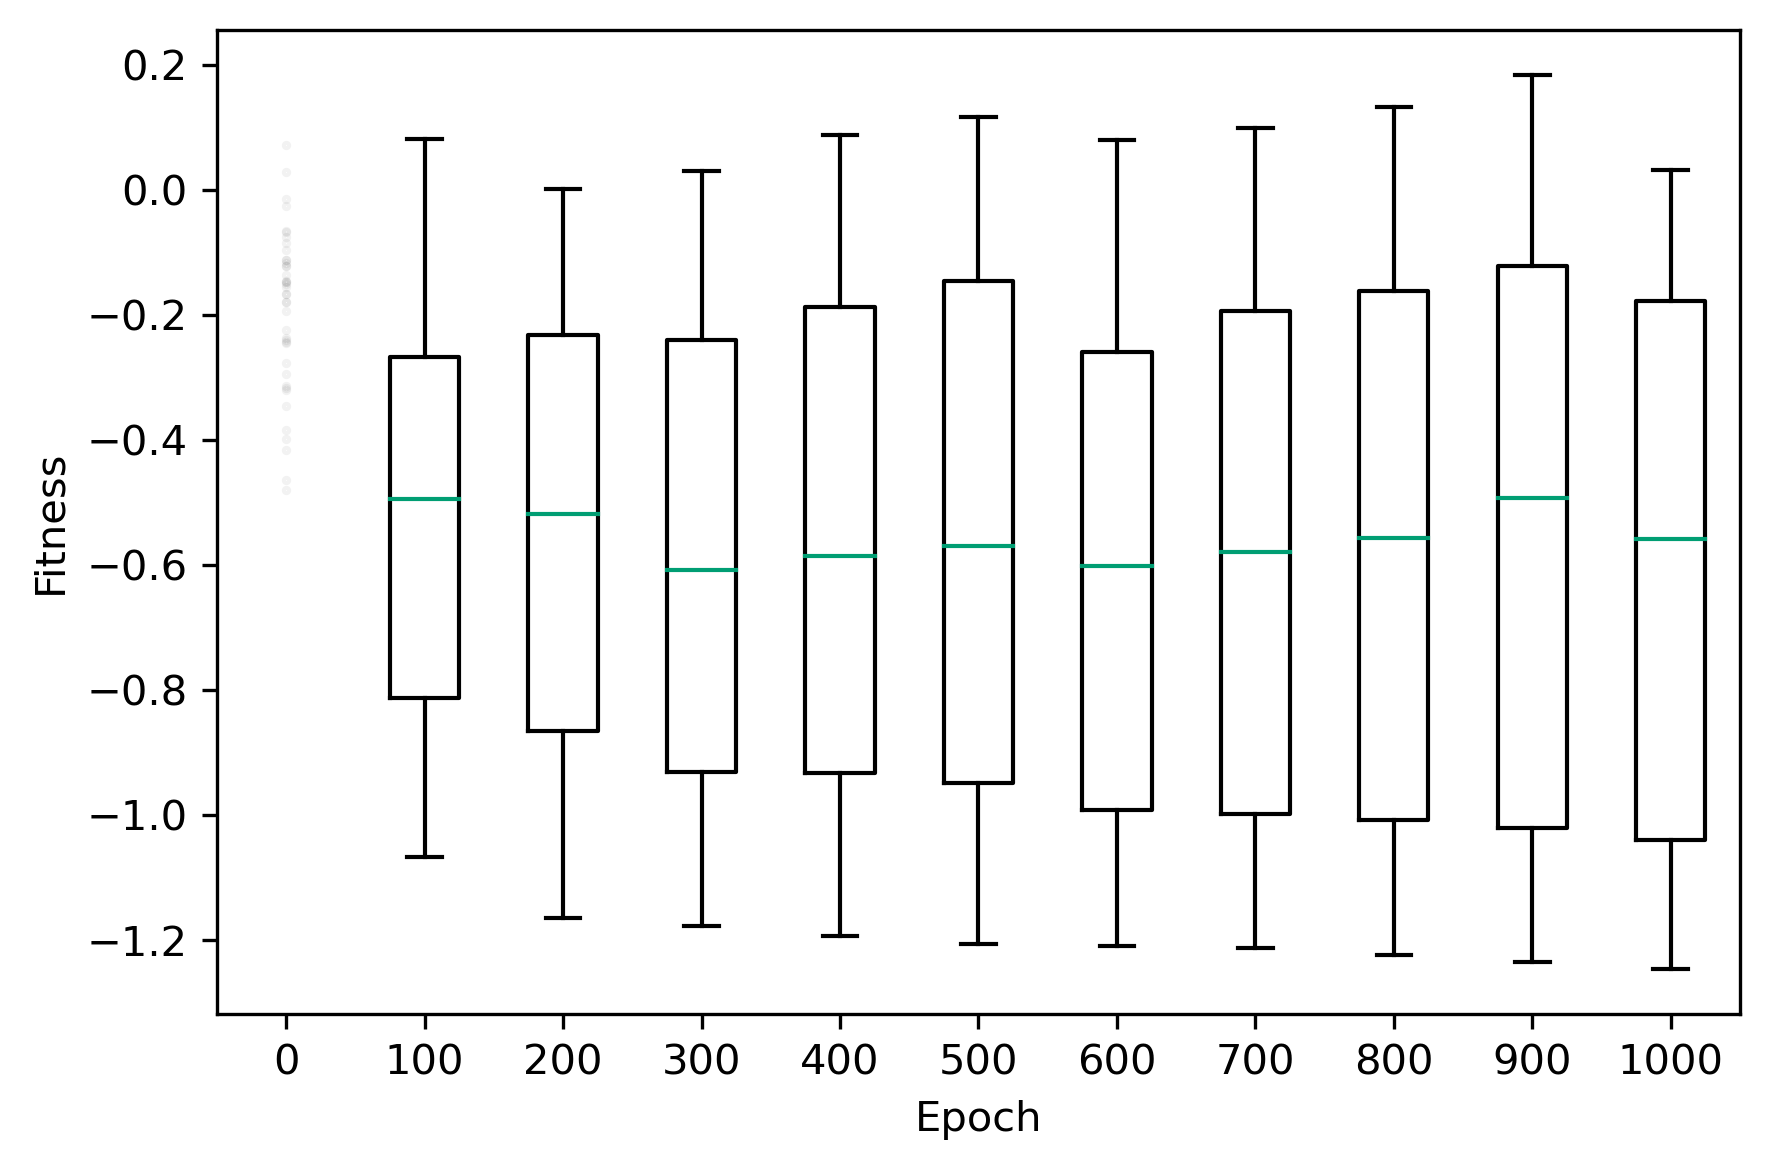

In [31]:
progression_boxplot(
    summary, "fitness", "Fitness", epochs=epochs, filename=name + "fitness.pdf"
)

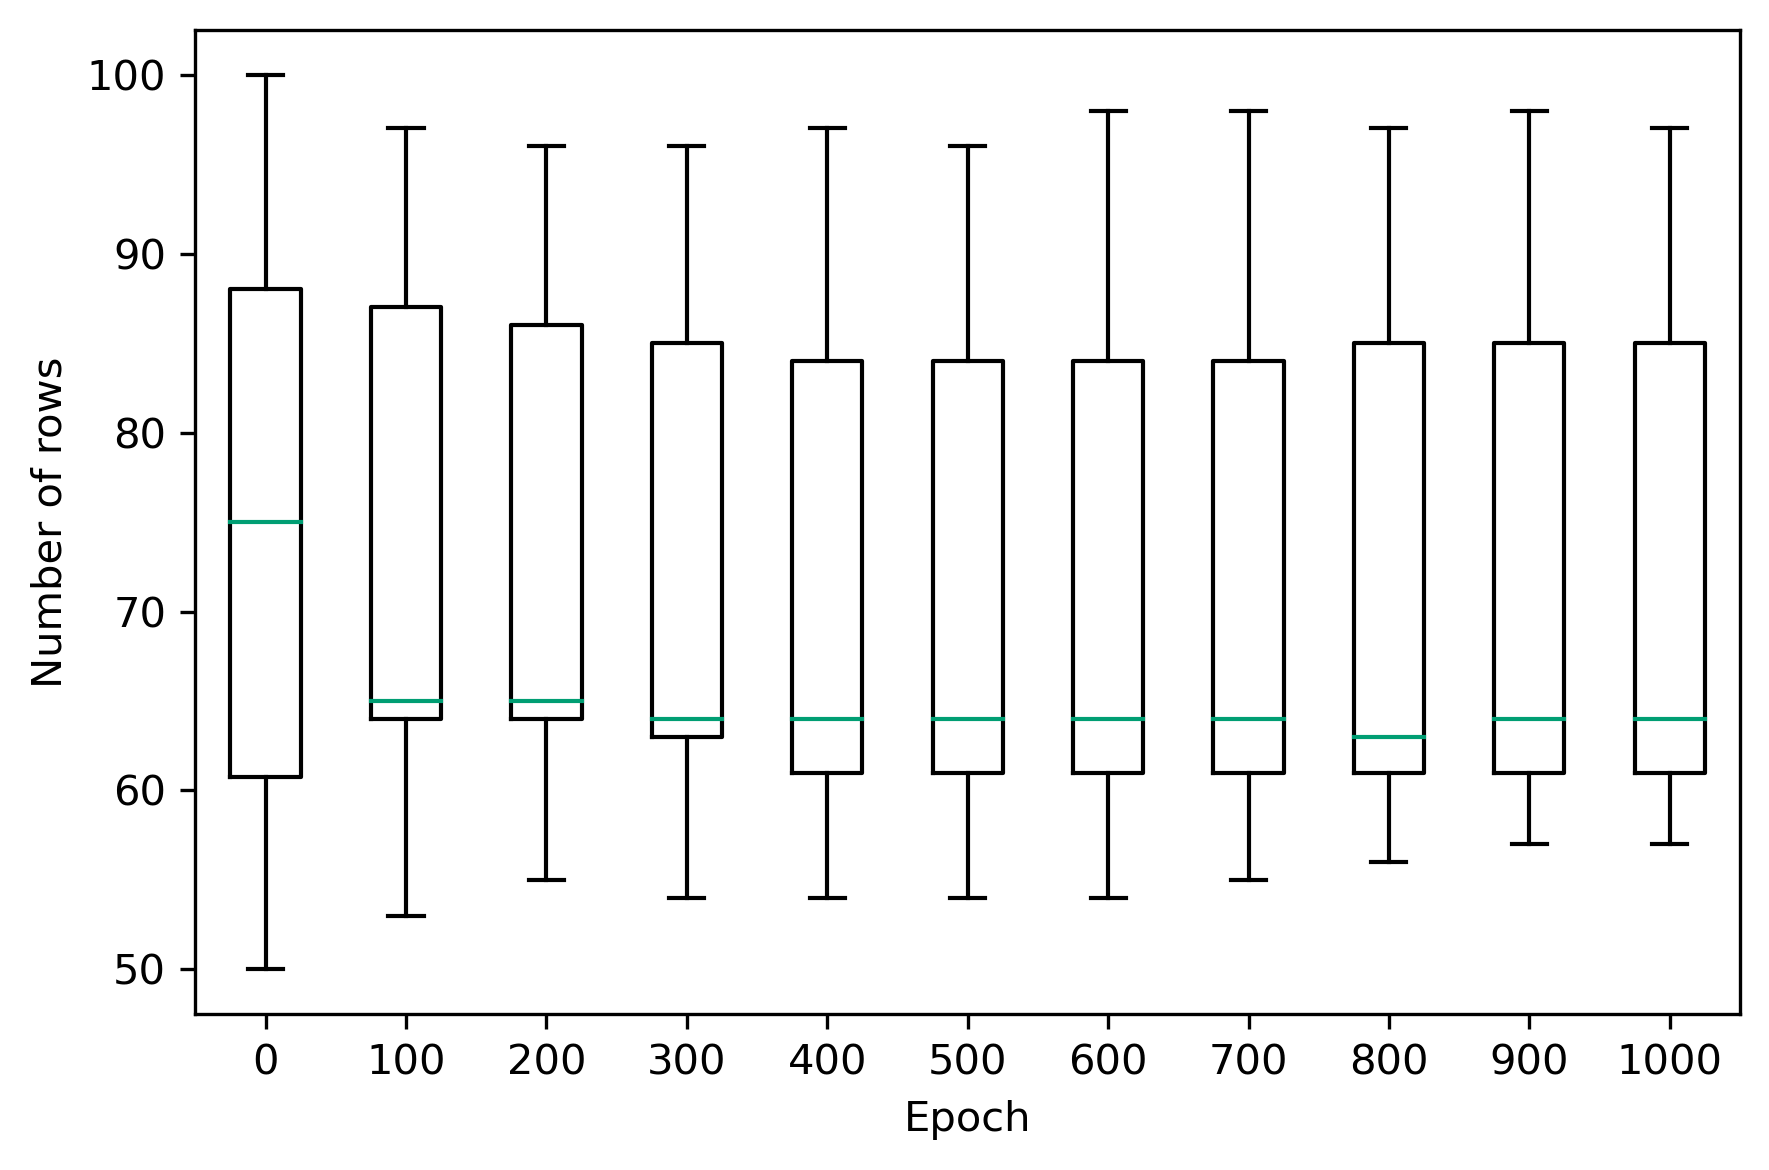

In [32]:
progression_boxplot(
    summary, "nrows", "Number of rows", epochs=epochs, filename=name + "nrows.pdf"
)

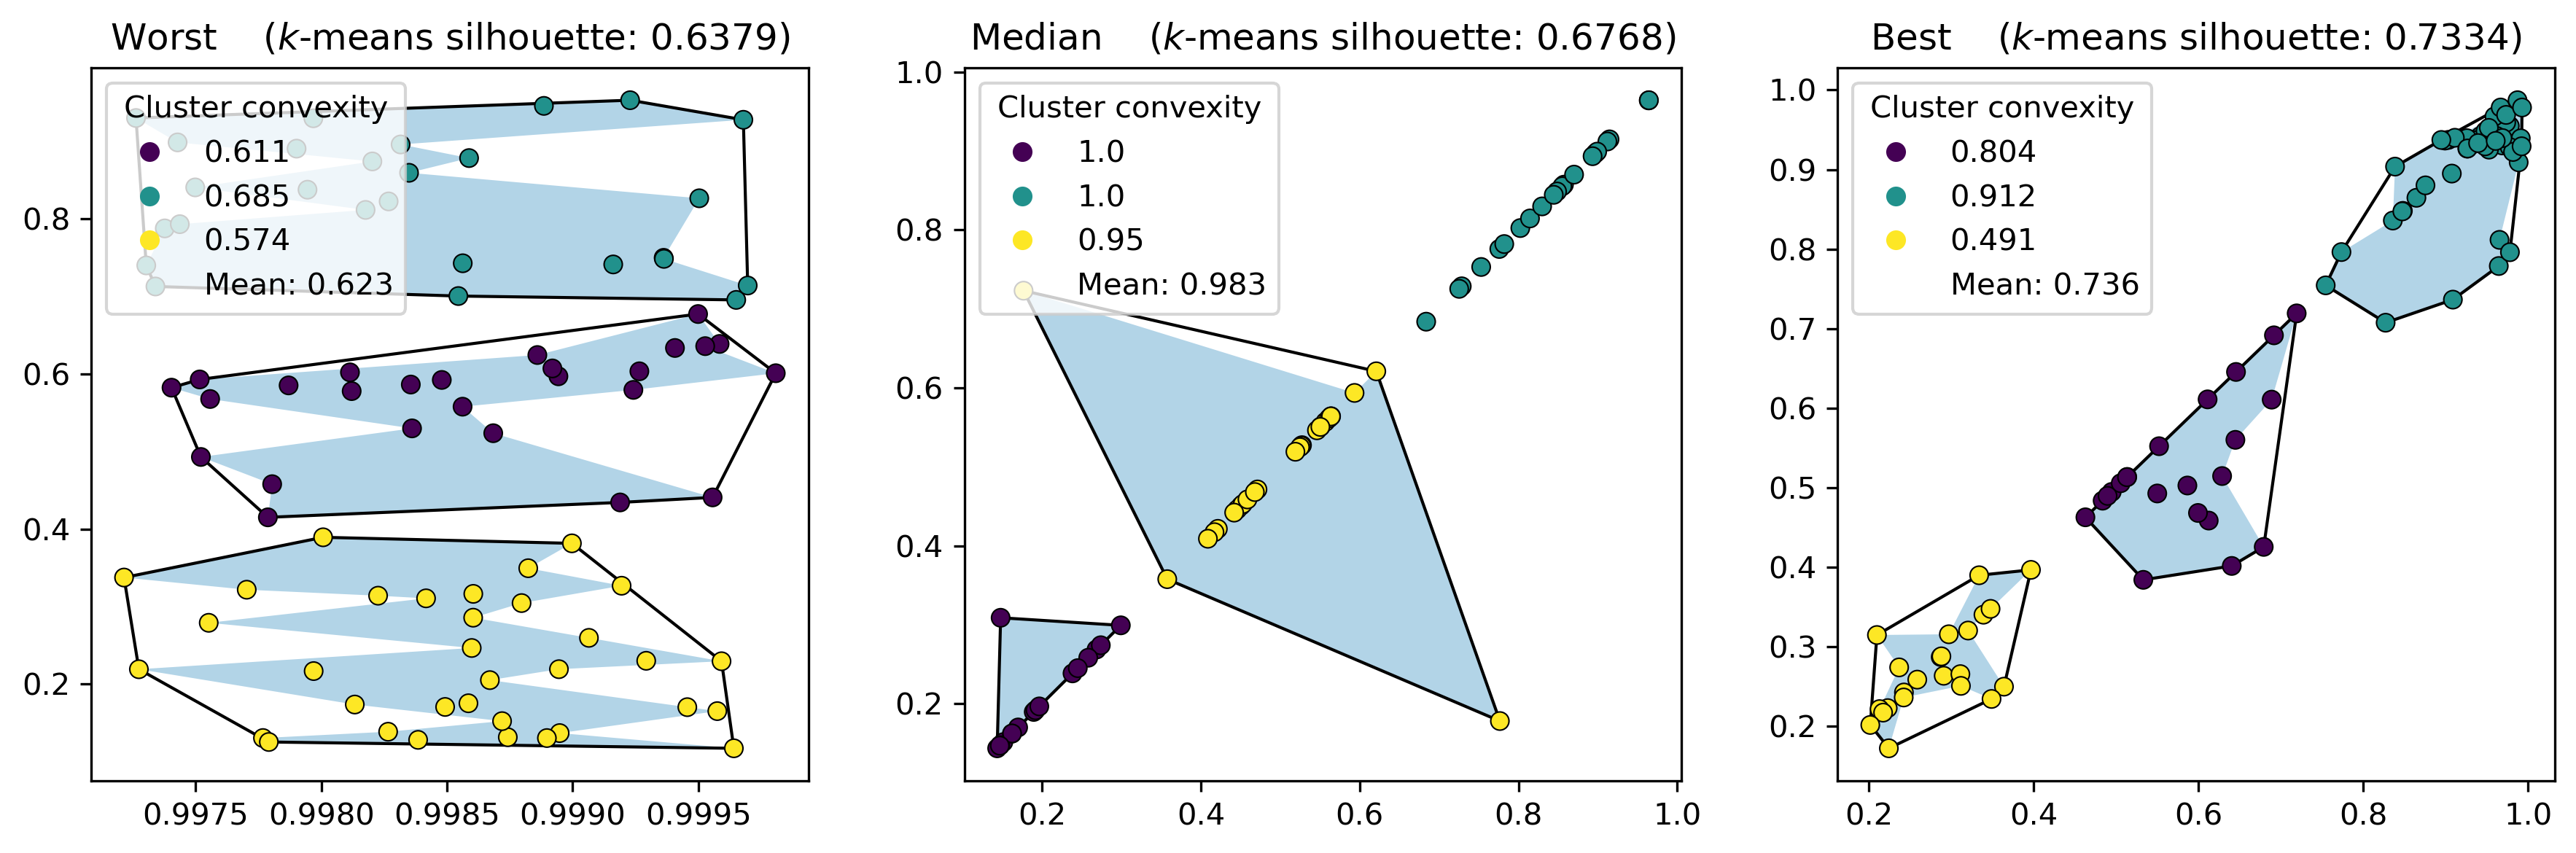

In [33]:
convexity_scatterplot(
    representatives, order, "kmeans", filename=name + "kmeans_inds.pdf"
)

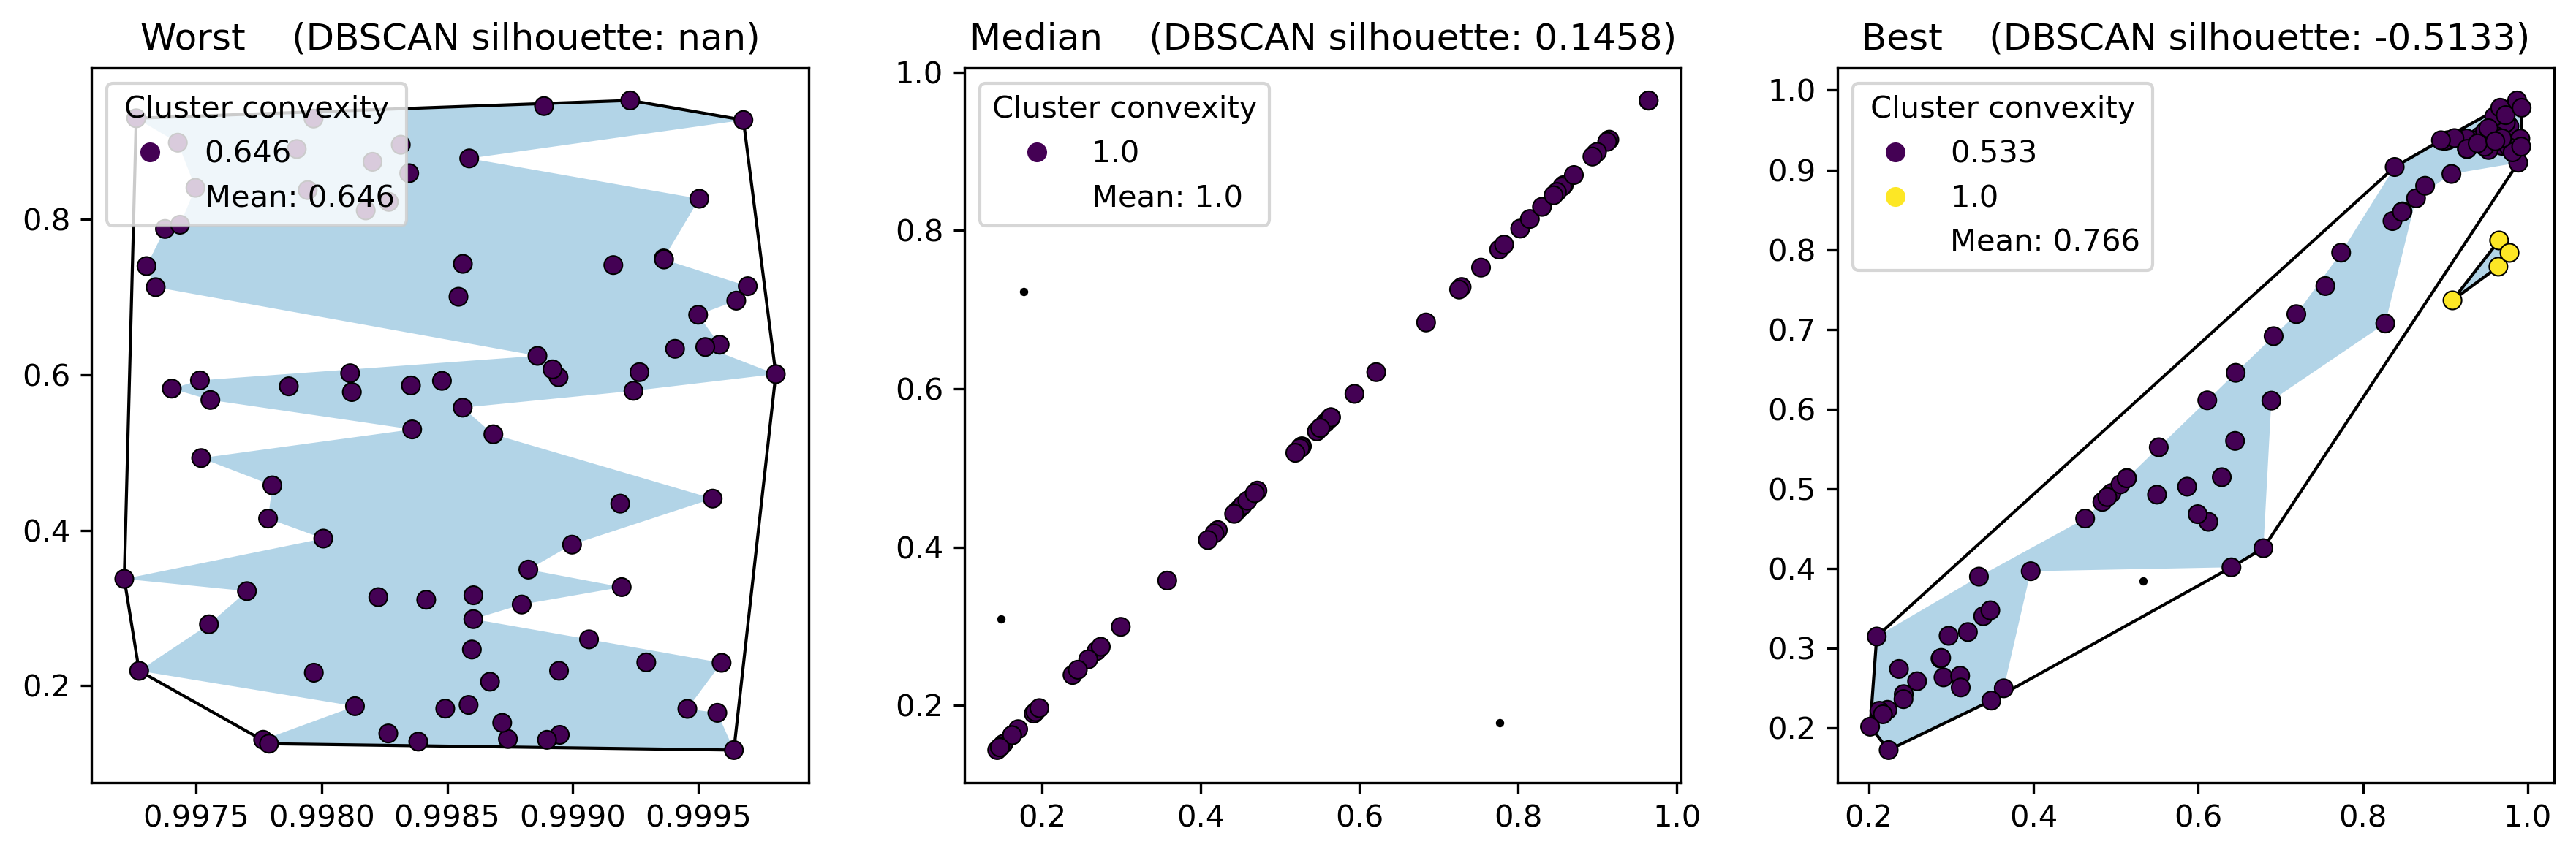

In [34]:
convexity_scatterplot(
    representatives, order, "dbscan", filename=name + "dbscan_inds.pdf"
)

## DBSCAN preferable over $k$-means

In [35]:
name = "dbscan_over_kmeans_"
summary = get_summary("dbscan_over_kmeans")
epochs = range(0, 1001, 100)

representatives = get_representatives("dbscan_over_kmeans")
order = ("max", "med", "min")

/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]


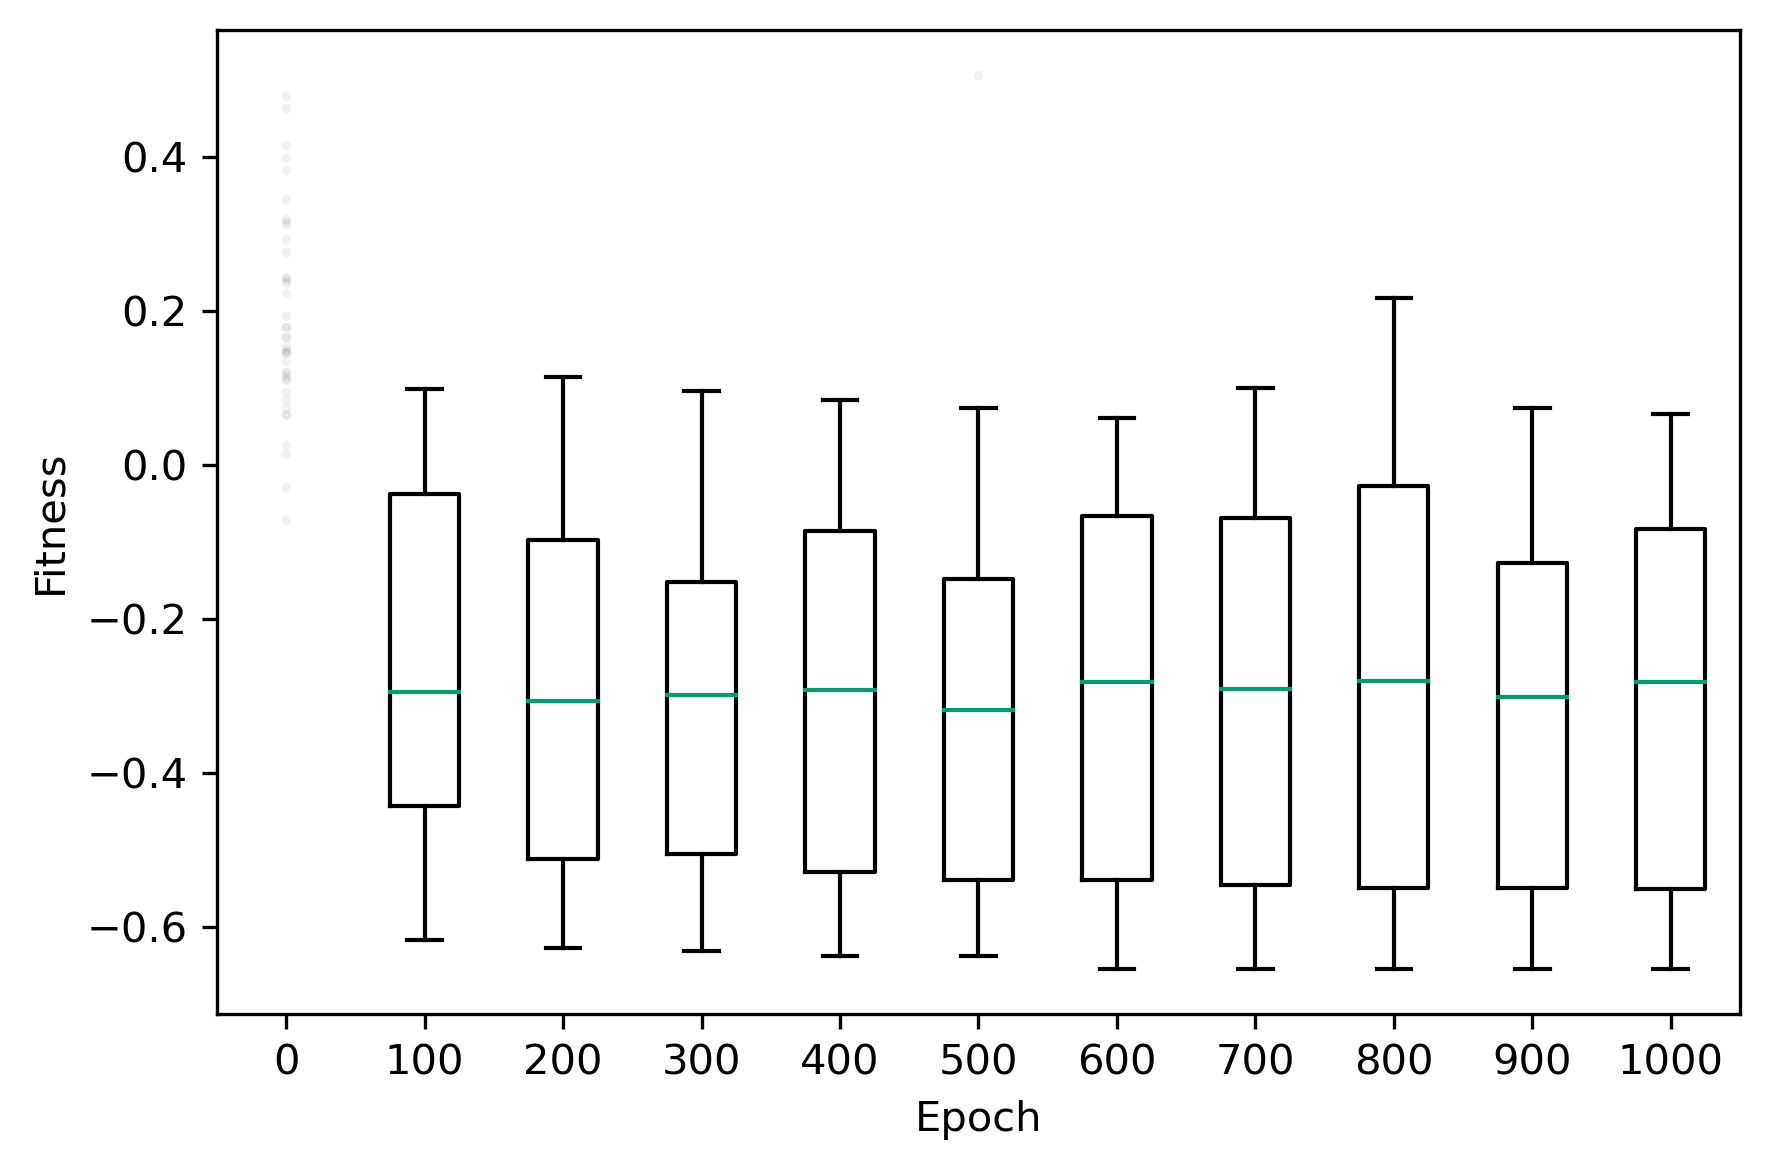

In [36]:
progression_boxplot(
    summary, "fitness", "Fitness", epochs=epochs, filename=name + "fitness.pdf"
)

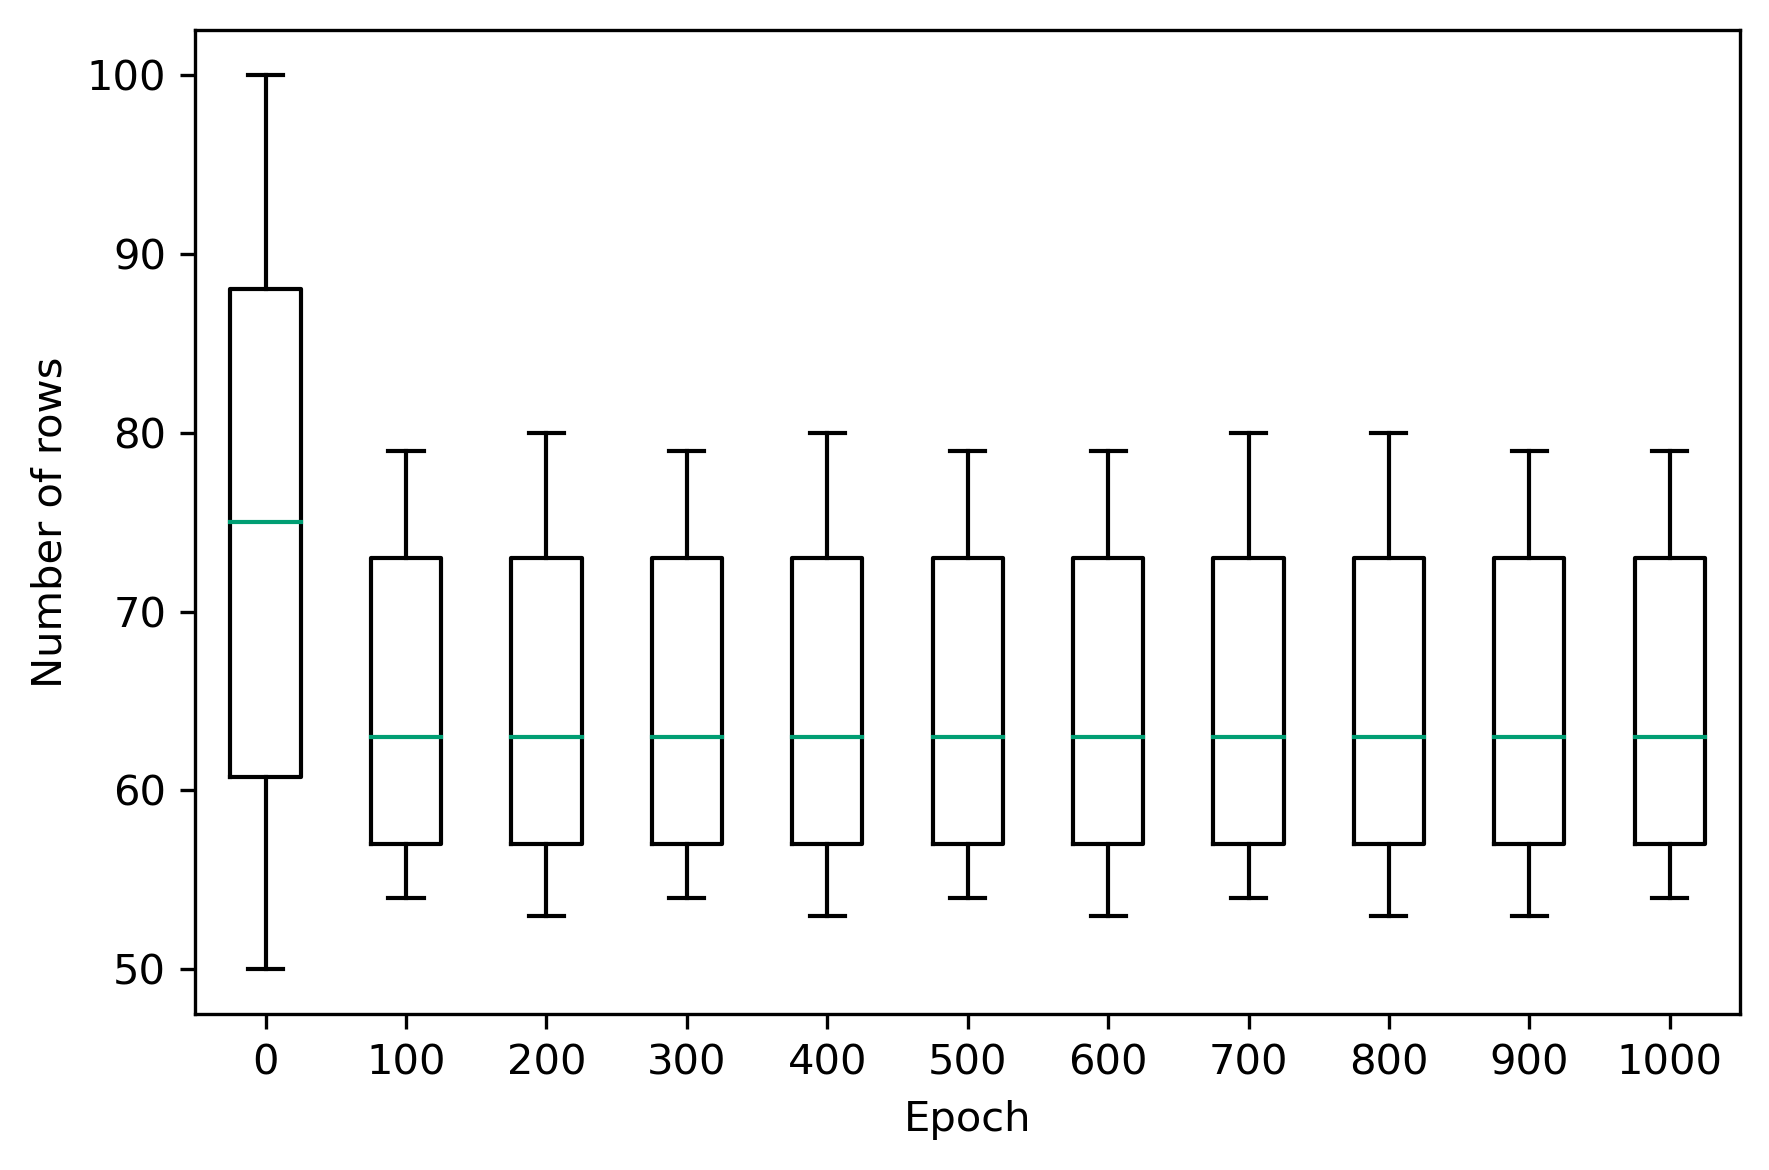

In [37]:
progression_boxplot(
    summary, "nrows", "Number of rows", epochs=epochs, filename=name + "nrows.pdf"
)

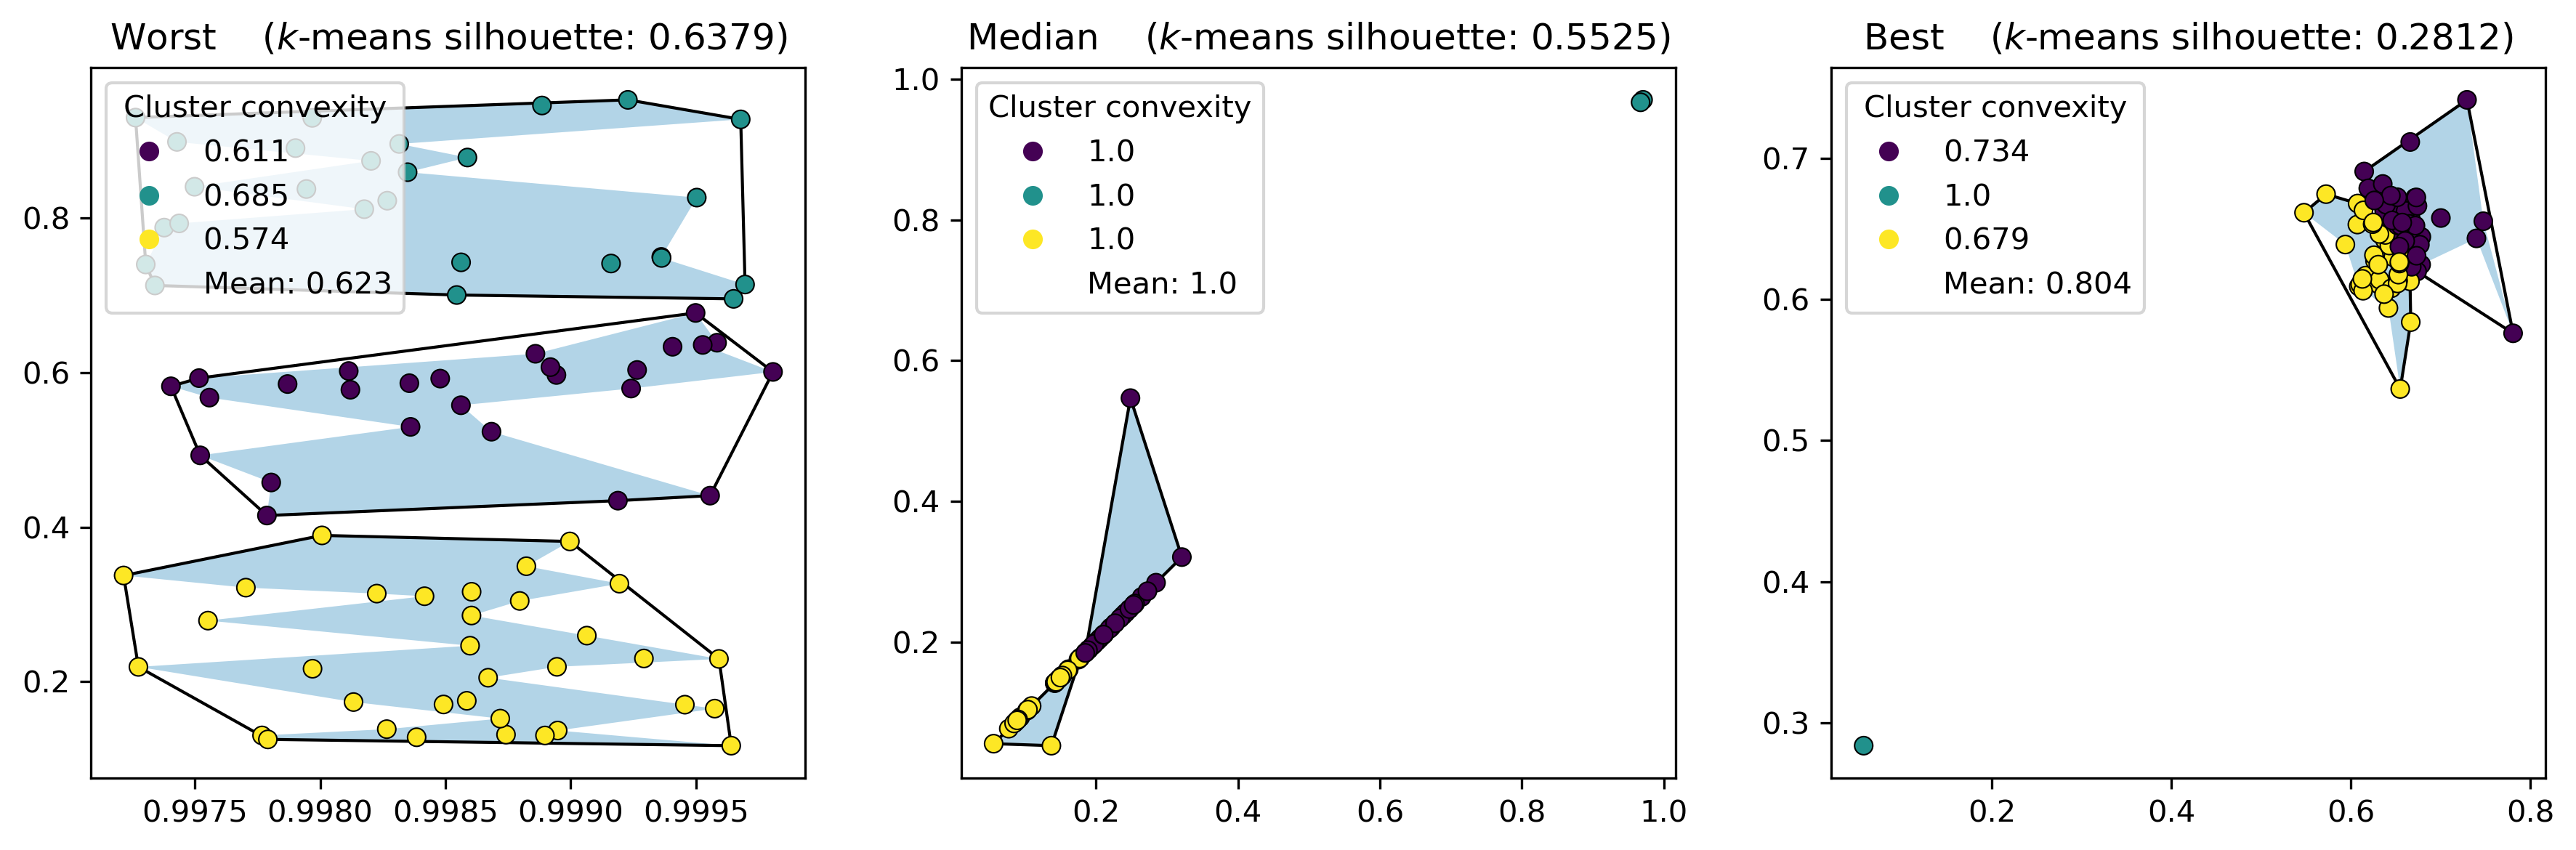

In [38]:
convexity_scatterplot(
    representatives, order, "kmeans", filename=name + "kmeans_inds.pdf"
)

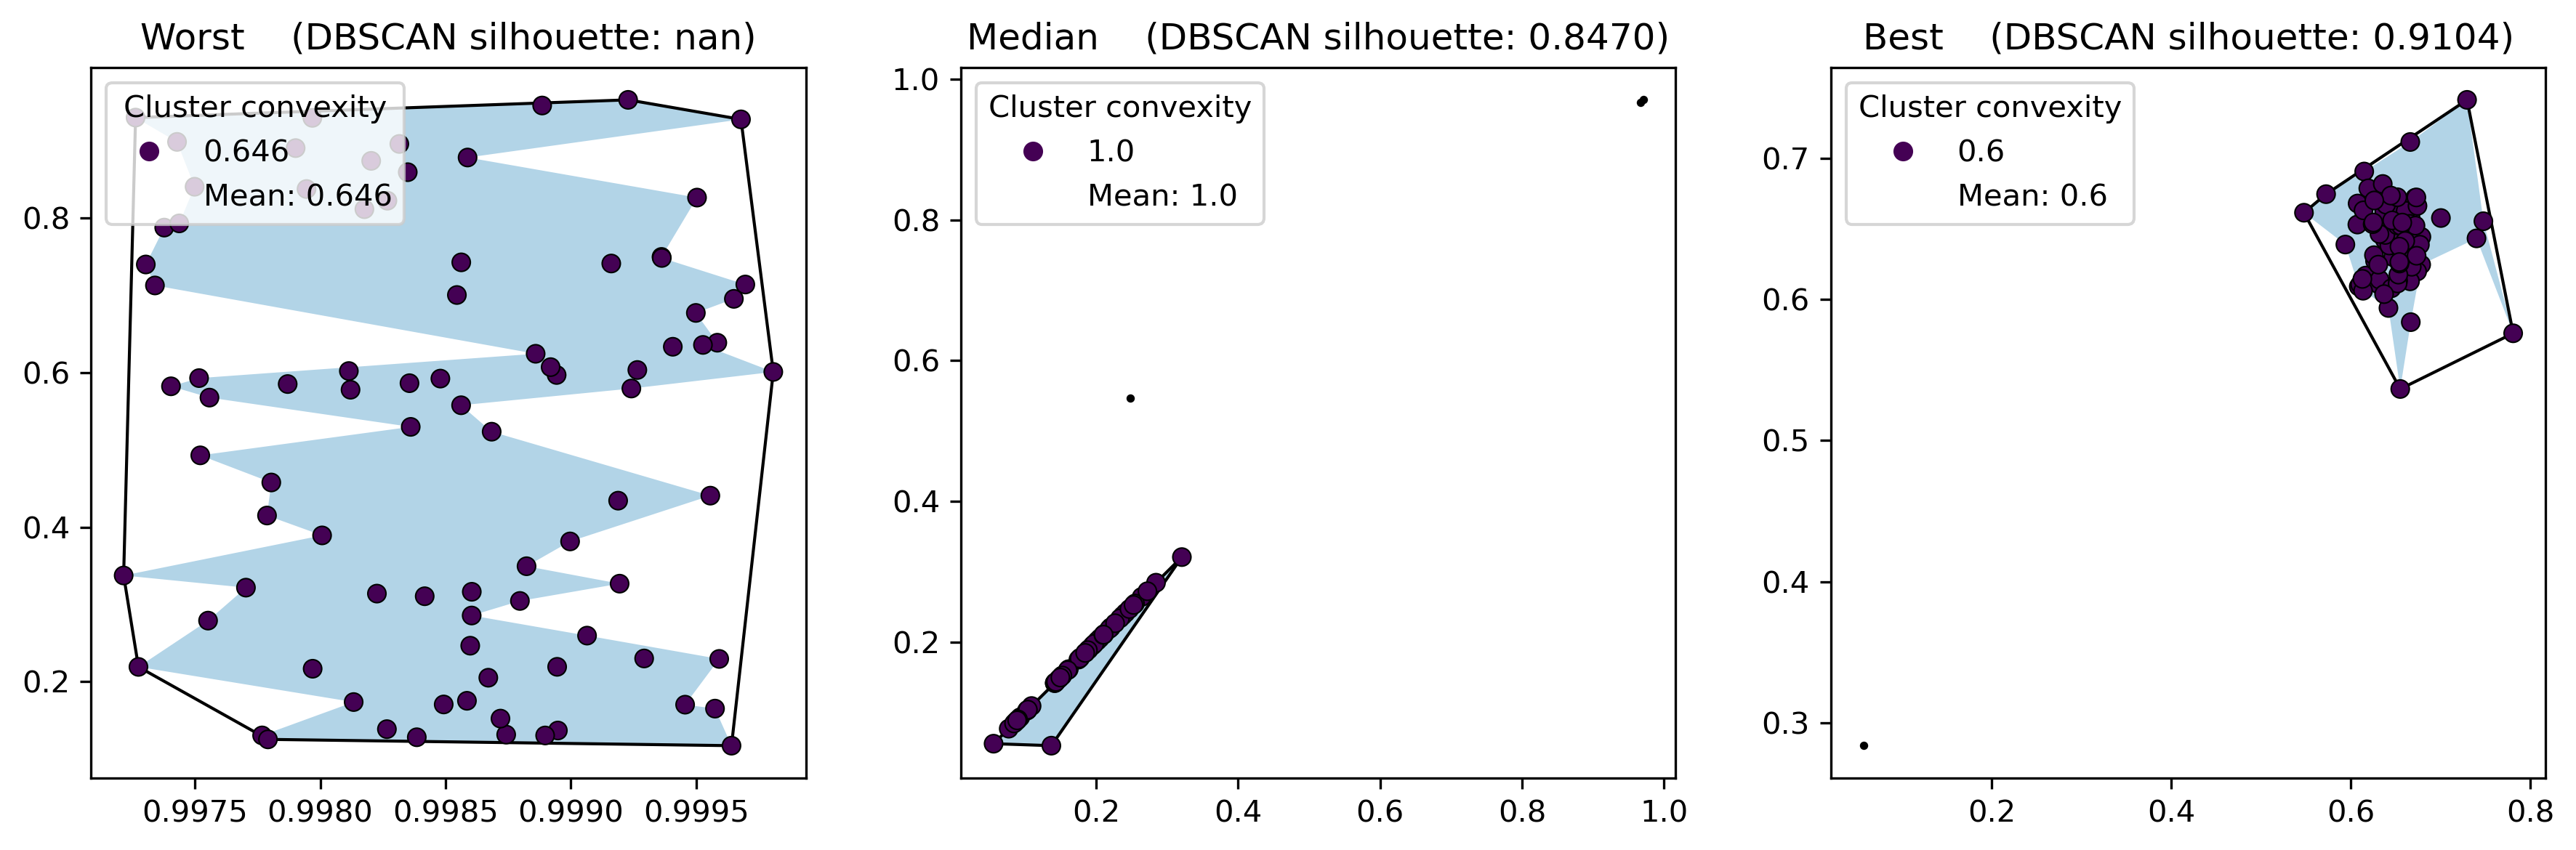

In [39]:
convexity_scatterplot(
    representatives, order, "dbscan", filename=name + "dbscan_inds.pdf"
)